In [143]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
%matplotlib inline


import seaborn as sns 
sns.set()

from scipy import stats
from scipy.stats import norm, skew

import os
print(os.listdir("../data_sorev"))

['data_description.txt', 'test.csv', 'sample_submission.csv', 'train.csv']


In [144]:
from catboost import CatBoostRegressor, Pool, cv

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.feature_selection import RFECV

import eli5
from eli5.sklearn import PermutationImportance

import hyperopt

from numpy.random import RandomState
from os import listdir


import shap
# load JS visualization code to notebook
shap.initjs()

In [145]:
listdir("../data_sorev")

['data_description.txt', 'test.csv', 'sample_submission.csv', 'train.csv']

In [325]:
train = pd.read_csv('../data_sorev/train.csv', index_col=0)
test = pd.read_csv('../data_sorev/test.csv', index_col=0)

In [147]:
def run_catboost(traindf, testdf, holddf, params, n_splits=10, n_repeats=1,
                 plot=False, use_features=None, plot_importance=True):
    
    
    folds = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
    p_hold = np.zeros(holddf.shape[0])
    y_hold = holddf.target
    p_test = np.zeros(testdf.shape[0])
    
    if use_features is None:
        use_features = testdf.columns.values
    
    cat_features = np.where(testdf.loc[:, use_features].dtypes=="object")[0]
    x_hold = holddf.loc[:, use_features]
    x_test = testdf.loc[:, use_features]
    
    feature_importance_df = pd.DataFrame(index=use_features)
    
    m = 0
    cv_scores = []
    for train_idx, dev_idx in folds.split(traindf):
        x_train, x_dev = traindf.iloc[train_idx][use_features], traindf.iloc[dev_idx][use_features]
        y_train, y_dev = traindf.target.iloc[train_idx], traindf.target.iloc[dev_idx]

        train_pool = Pool(x_train, y_train, cat_features=cat_features)
        dev_pool = Pool(x_dev, y_dev, cat_features=cat_features)
        model = CatBoostRegressor(**params)
        model.fit(train_pool, eval_set=dev_pool, plot=plot)

        # bagging predictions for test and hold out data:
        p_hold += model.predict(x_hold)/(n_splits*n_repeats)
        log_p_test = model.predict(x_test)
        p_test += (np.exp(log_p_test) - 1)/(n_splits*n_repeats)

        # predict for dev fold:
        y_pred = model.predict(x_dev)
        feature_importance_df.loc[:, "fold_" + str(m)] = model.get_feature_importance(train_pool)
        cv_scores.append(np.sqrt(mse(y_dev, y_pred)))
        m+=1

    print("hold out rmse: " + str(np.sqrt(mse(y_hold, p_hold))))
    print("cv mean rmse: " + str(np.mean(cv_scores)))
    print("cv std rmse: " + str(np.std(cv_scores)))
    
    feature_importance_df["mean"] = feature_importance_df.mean(axis=1)
    feature_importance_df["std"] = feature_importance_df.std(axis=1)
    feature_importance_df = feature_importance_df.sort_values(by="mean", ascending=False)
    
    if plot_importance:
        plt.figure(figsize=(15,20))
        sns.barplot(x=feature_importance_df["mean"].values[0:50], y=feature_importance_df.index.values[0:50]);
        plt.title("Feature importances");
        plt.show()
    
    results = {"last_model": model,
               "last_train_pool": train_pool,
               "feature_importance": feature_importance_df, 
               "p_hold": p_hold,
               "p_test": p_test,
               "cv_scores": cv_scores}
    return results

In [148]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [326]:
train.shape

(1460, 80)

In [150]:
train.describe(include='all')

Id   MSSubClass MSZoning  LotFrontage        LotArea Street  \
count   1460.000000  1460.000000     1460  1201.000000    1460.000000   1460   
unique          NaN          NaN        5          NaN            NaN      2   
top             NaN          NaN       RL          NaN            NaN   Pave   
freq            NaN          NaN     1151          NaN            NaN   1454   
mean     730.500000    56.897260      NaN    70.049958   10516.828082    NaN   
std      421.610009    42.300571      NaN    24.284752    9981.264932    NaN   
min        1.000000    20.000000      NaN    21.000000    1300.000000    NaN   
25%      365.750000    20.000000      NaN    59.000000    7553.500000    NaN   
50%      730.500000    50.000000      NaN    69.000000    9478.500000    NaN   
75%     1095.250000    70.000000      NaN    80.000000   11601.500000    NaN   
max     1460.000000   190.000000      NaN   313.000000  215245.000000    NaN   

       Alley LotShape LandContour Utilities  ...     PoolArea PoolQC  Fence  \
count     91     1460        1460      1460  ...  1460.000000      7    281   
unique     2        4           4         2  ...          NaN      3      4   
top     Grvl      Reg         Lvl    AllPub  ...          NaN     Gd  MnPrv   
freq      50      925        1311      1459  ...          NaN      3    157   
mean     NaN      NaN         NaN       NaN  ...     2.758904    NaN    NaN   
std      NaN      NaN         NaN       NaN  ...    40.177307    NaN    NaN   
min      NaN      NaN         NaN       NaN  ...     0.000000    NaN    NaN   
25%      NaN      NaN         NaN       NaN  ...     0.000000    NaN    NaN   
50%      NaN      NaN         NaN       NaN  ...     0.000000    NaN    NaN   
75%      NaN      NaN         NaN       NaN  ...     0.000000    NaN    NaN   
max      NaN      NaN         NaN       NaN  ...   738.000000    NaN    NaN   

       MiscFeature       MiscVal       MoSold       YrSold  SaleType  \
count           54   1460.000000  1460.000000  1460.000000      1460   
unique           4           NaN          NaN          NaN         9   
top           Shed           NaN          NaN          NaN        WD   
freq            49           NaN          NaN          NaN      1267   
mean           NaN     43.489041     6.321918  2007.815753       NaN   
std            NaN    496.123024     2.703626     1.328095       NaN   
min            NaN      0.000000     1.000000  2006.000000       NaN   
25%            NaN      0.000000     5.000000  2007.000000       NaN   
50%            NaN      0.000000     6.000000  2008.000000       NaN   
75%            NaN      0.000000     8.000000  2009.000000       NaN   
max            NaN  15500.000000    12.000000  2010.000000       NaN   

        SaleCondition      SalePrice  
count            1460    1460.000000  
unique              6            NaN  
top            Normal            NaN  
freq             1198            NaN  
mean              NaN  180921.195890  
std               NaN   79442.502883  
min               NaN   34900.000000  
25%               NaN  129975.000000  
50%               NaN  163000.000000  
75%               NaN  214000.000000  
max               NaN  755000.000000  

[11 rows x 81 columns]

In [151]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [152]:
train.info(int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [327]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

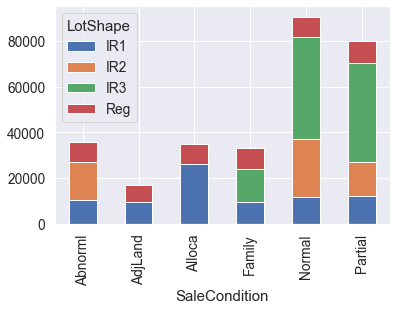

In [328]:
train.pivot_table('LotArea', 'SaleCondition', 'LotShape').plot(kind='bar', stacked=True)

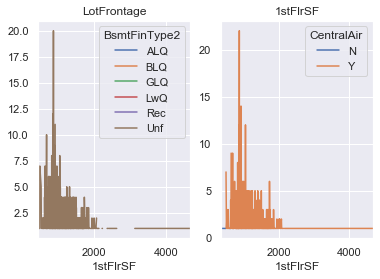

In [14]:
fig, axes = plt.subplots(ncols=2)
train.pivot_table('SalePrice', ['1stFlrSF'], 'BsmtFinType2', 'count').plot(ax=axes[0], title='LotFrontage')
train.pivot_table('SalePrice', ['1stFlrSF'], 'CentralAir', 'count').plot(ax=axes[1], title='1stFlrSF')

     


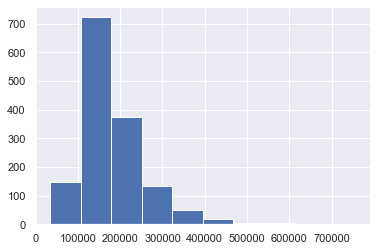

In [15]:
train['SalePrice'].hist();


 mu = 180921.20 and sigma = 79415.29



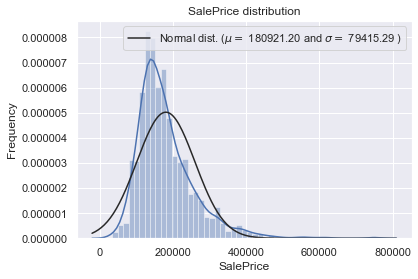

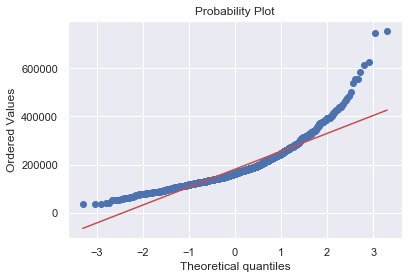

In [16]:
#plt.figure(figsize=(20,5))
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show() 

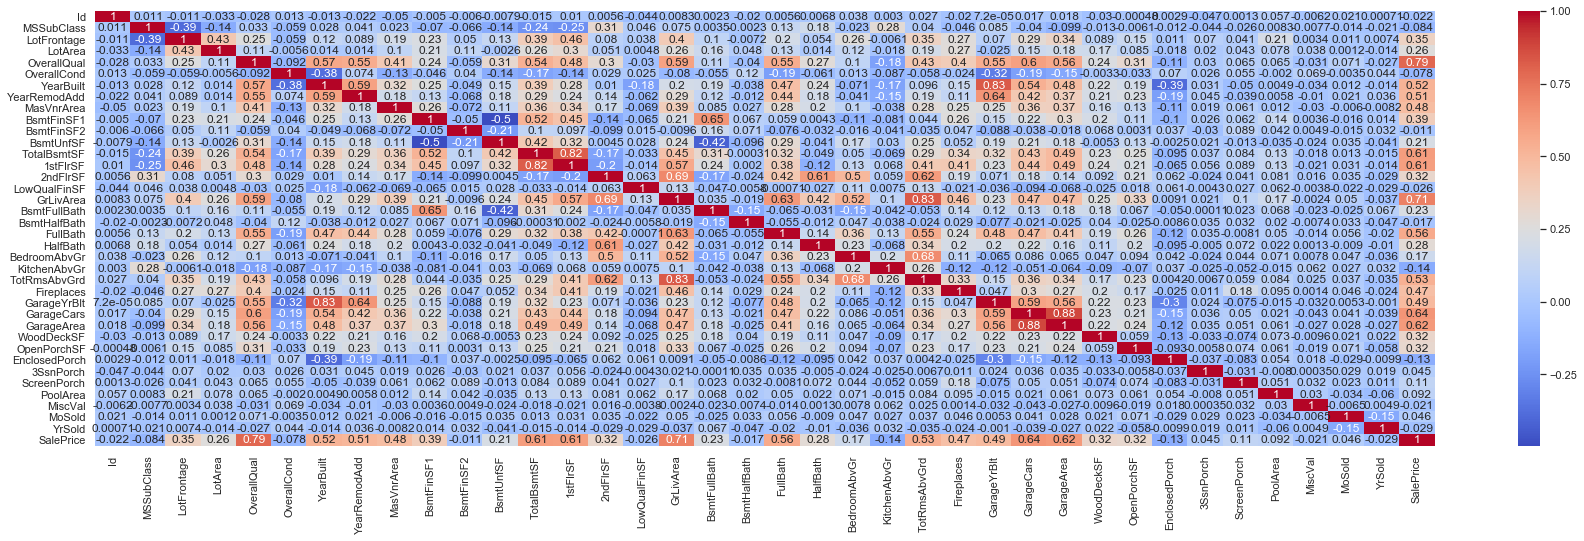

In [17]:
plt.figure(figsize=(30,8))
sns.heatmap(train.corr(),cmap='coolwarm',annot = True)
plt.show()

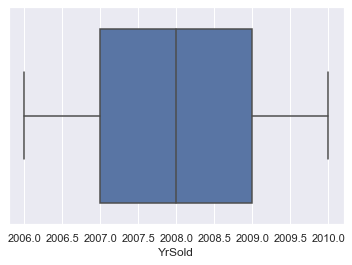

In [18]:
sns.boxplot(train['YrSold']);

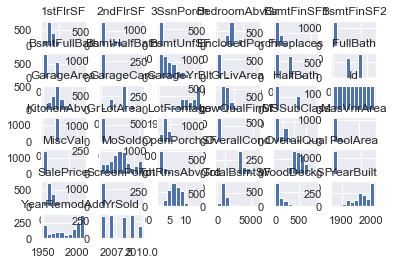

In [19]:
train.hist();

In [20]:
train['LotShape'].value_counts()

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

In [21]:
train['LotShape'].value_counts(1)

Reg    0.633562
IR1    0.331507
IR2    0.028082
IR3    0.006849
Name: LotShape, dtype: float64

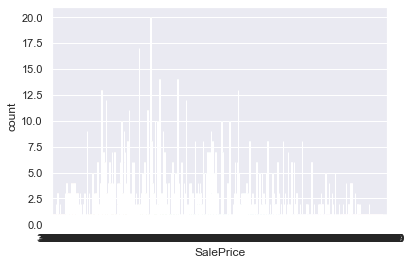

In [22]:
sns.countplot(train['SalePrice']);

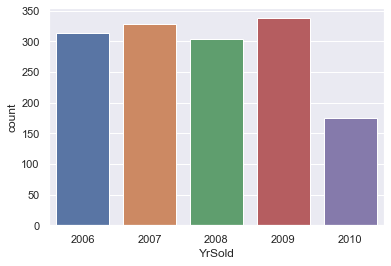

In [23]:
sns.countplot(train['YrSold']);

In [24]:
fig, axes = plt.subplots(ncols=)
train.pivot_table('SalePrice', ['LotArea'], 'SaleCondition', 'count').plot(ax=axes[0], title='LotArea')


SyntaxError: invalid syntax (<ipython-input-24-c4d3cff1e161>, line 1)

In [27]:
train.pivot_table('SalePrice', ['OverallQual'], 'SaleCondition', 'count').plot(ax=axes[1], title='OverallQual')


In [28]:
train.pivot_table('SalePrice', ['TotalBsmtSF'], 'SaleCondition', 'count').plot(ax=axes[0], title='TotalBsmtSF')


In [29]:
train.pivot_table('SalePrice', ['YrSold'], 'SaleCondition', 'count').plot(ax=axes[1], title='YrSold')

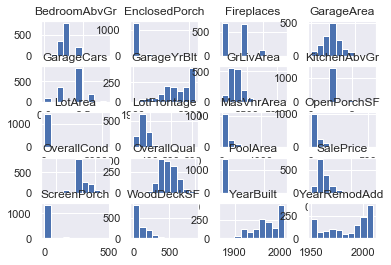

In [30]:
feat = [f for f in train.columns if 'e' in f]

train[feat].hist();

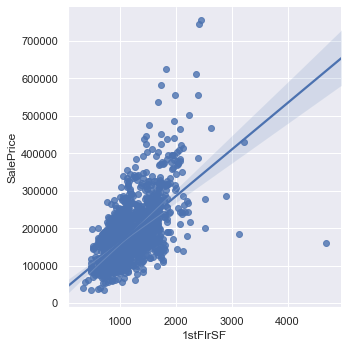

In [31]:
sns.lmplot(x='1stFlrSF',y='SalePrice',data=train)

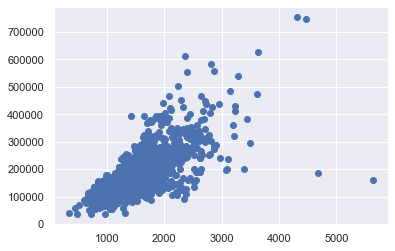

In [32]:
plt.scatter(x= 'GrLivArea', y='SalePrice', data = train)

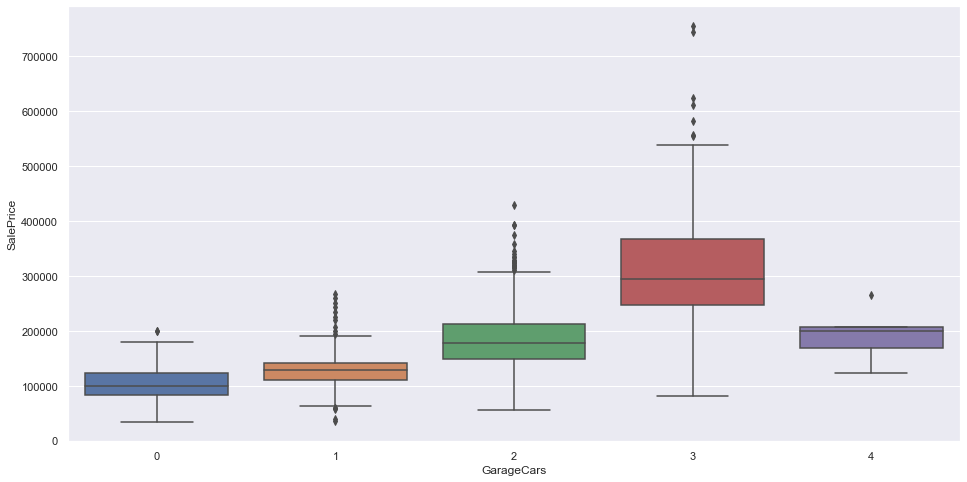

In [33]:
plt.figure(figsize=(16,8))
sns.boxplot(x='GarageCars',y='SalePrice',data=train)
plt.show()

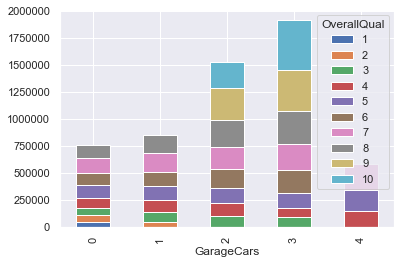

In [34]:

train.pivot_table('SalePrice', 'GarageCars', 'OverallQual').plot(kind='bar', stacked=True)

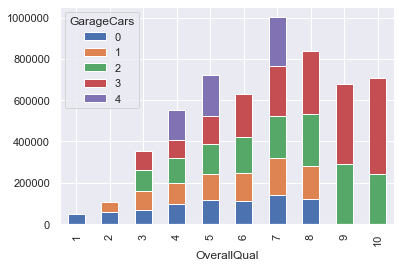

In [35]:
train.pivot_table('SalePrice', 'OverallQual', 'GarageCars').plot(kind='bar', stacked=True)

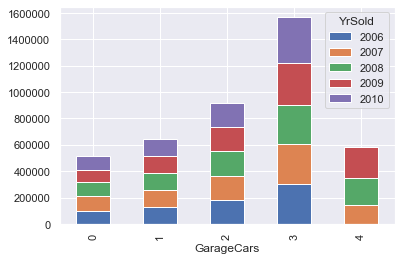

In [36]:
train.pivot_table('SalePrice', 'GarageCars', 'YrSold').plot(kind='bar', stacked=True)

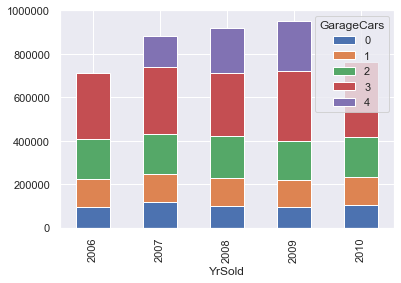

In [37]:
train.pivot_table('SalePrice', 'YrSold', 'GarageCars').plot(kind='bar', stacked=True)

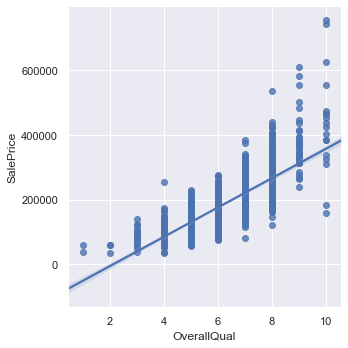

In [38]:
sns.lmplot(x='OverallQual',y='SalePrice',data=train)

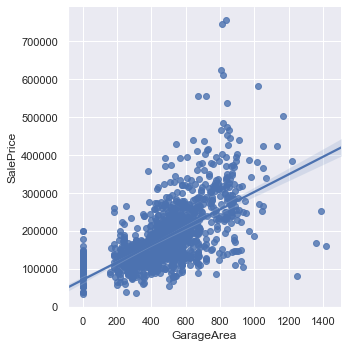

In [39]:
sns.lmplot(x='GarageArea',y='SalePrice',data=train)

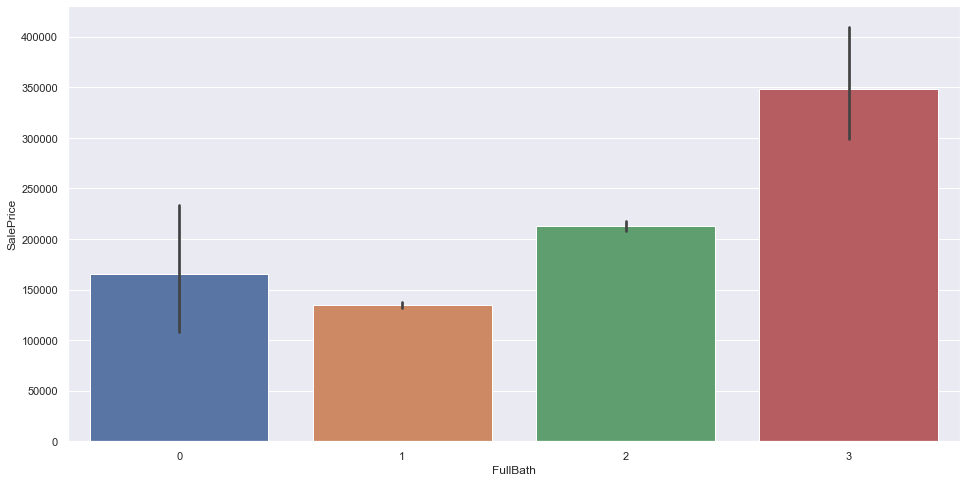

In [40]:
plt.figure(figsize=(16,8))
sns.barplot(x='FullBath',y = 'SalePrice',data=train)
plt.show()

In [407]:
combined = train.drop("SalePrice", axis=1).append(test)
nan_percentage = combined.isnull().sum().sort_values(ascending=False) / combined.shape[0]
missing_val = nan_percentage[nan_percentage > 0]
combined.shape

(2919, 79)

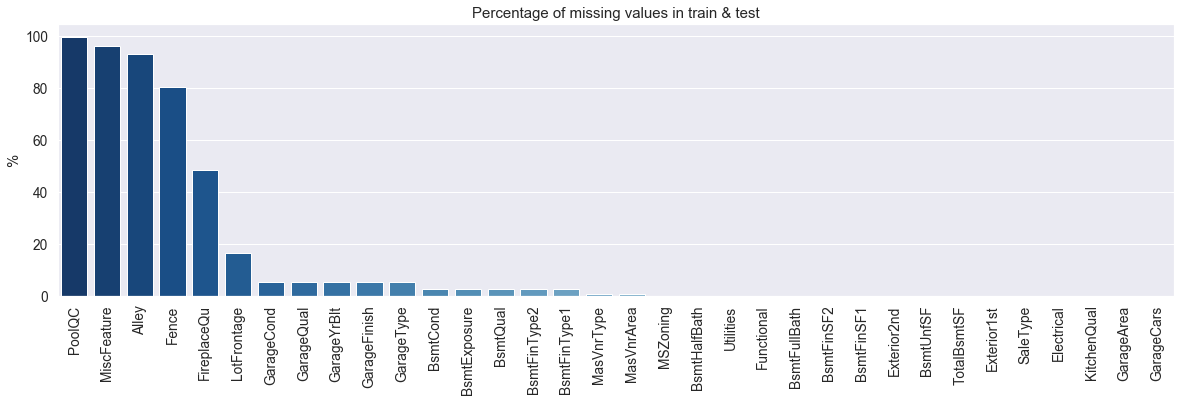

In [408]:
plt.figure(figsize=(20,5))
sns.barplot(x=missing_val.index.values, y=missing_val.values * 100, palette="Blues_r");
plt.title("Percentage of missing values in train & test");
plt.ylabel("%");
plt.xticks(rotation=90);

In [409]:
    total = train.isnull().sum().sort_values(ascending=False)
    percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data.head(25)

Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageType       81  0.055479
GarageCond       81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
GarageYrBlt      81  0.055479
BsmtFinType2     38  0.026027
BsmtExposure     38  0.026027
BsmtQual         37  0.025342
BsmtCond         37  0.025342
BsmtFinType1     37  0.025342
MasVnrArea        8  0.005479
MasVnrType        8  0.005479
Electrical        1  0.000685
RoofMatl          0  0.000000
Exterior1st       0  0.000000
RoofStyle         0  0.000000
ExterQual         0  0.000000
Exterior2nd       0  0.000000
YearBuilt         0  0.000000

In [410]:
to_drop = missing_val[missing_val > 0.1].index.values
combined = combined.drop(to_drop, axis=1)
combined.shape

(2919, 73)

In [411]:
to_drop

array(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
       'LotFrontage'], dtype=object)

In [412]:
train_1 = train.drop((missing_data[missing_data['Total'] > 81]).index,1)

In [413]:
train.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageCond        81
GarageFinish      81
GarageQual        81
GarageYrBlt       81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
RoofMatl           0
dtype: int64

In [414]:
train_1.isnull().sum().sort_values(ascending=False).head(20)

GarageType      81
GarageYrBlt     81
GarageFinish    81
GarageQual      81
GarageCond      81
BsmtFinType2    38
BsmtExposure    38
BsmtFinType1    37
BsmtCond        37
BsmtQual        37
MasVnrType       8
MasVnrArea       8
Electrical       1
YearRemodAdd     0
ExterQual        0
ExterCond        0
Exterior2nd      0
Exterior1st      0
Foundation       0
BsmtFinSF1       0
dtype: int64

In [415]:
total_test = test.isnull().sum().sort_values(ascending=False)
percent_test = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_test, percent_test], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

Total   Percent
PoolQC         1456  0.997944
MiscFeature    1408  0.965045
Alley          1352  0.926662
Fence          1169  0.801234
FireplaceQu     730  0.500343
LotFrontage     227  0.155586
GarageCond       78  0.053461
GarageFinish     78  0.053461
GarageYrBlt      78  0.053461
GarageQual       78  0.053461
GarageType       76  0.052090
BsmtCond         45  0.030843
BsmtExposure     44  0.030158
BsmtQual         44  0.030158
BsmtFinType1     42  0.028787
BsmtFinType2     42  0.028787
MasVnrType       16  0.010966
MasVnrArea       15  0.010281
MSZoning          4  0.002742
BsmtHalfBath      2  0.001371
Utilities         2  0.001371
Functional        2  0.001371
BsmtFullBath      2  0.001371
BsmtFinSF2        1  0.000685
BsmtFinSF1        1  0.000685

In [416]:
test_1 = test.drop((missing_data[missing_data['Total'] > 78]).index,1)

In [417]:
test.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageFinish      78
GarageYrBlt       78
GarageQual        78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
dtype: int64

In [418]:
test_1.isnull().sum().sort_values(ascending=False).head(20)

GarageQual      78
GarageCond      78
GarageYrBlt     78
GarageFinish    78
GarageType      76
BsmtCond        45
BsmtQual        44
BsmtExposure    44
BsmtFinType1    42
BsmtFinType2    42
MasVnrType      16
MasVnrArea      15
MSZoning         4
Functional       2
BsmtHalfBath     2
BsmtFullBath     2
Utilities        2
KitchenQual      1
Exterior2nd      1
SaleType         1
dtype: int64

In [419]:
cat_candidates = combined.dtypes[combined.dtypes=="object"].index.values
cat_candidates

array(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'], dtype=object)

In [420]:
#Another method - to list
categorical_feature_mask = train.dtypes==object
categorical_cols = train.columns[categorical_feature_mask].tolist()
categorical_cols


['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

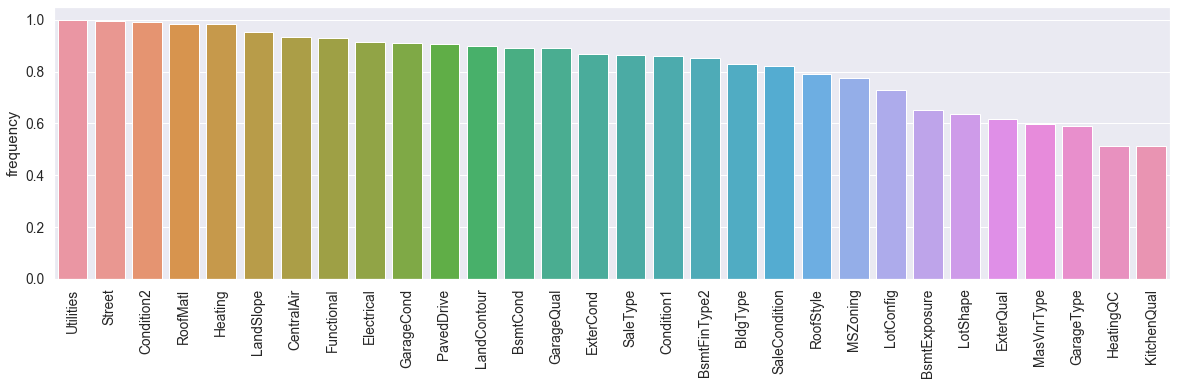

In [421]:
frequencies = []
for col in cat_candidates:
    overall_freq = combined.loc[:, col].value_counts().max() / combined.shape[0]
    frequencies.append([col, overall_freq])

frequencies = np.array(frequencies)
freq_df = pd.DataFrame(index=frequencies[:,0], data=frequencies[:,1], columns=["frequency"])
sorted_freq = freq_df.frequency.sort_values(ascending=False)

plt.figure(figsize=(20,5))
sns.barplot(x=sorted_freq.index[0:30], y=sorted_freq[0:30].astype(np.float))
plt.xticks(rotation=90);

In [422]:
example = "Utilities"
combined.loc[:,example].value_counts()

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

In [430]:
freq_df.frequency = freq_df.frequency.astype(np.float)
cats_to_drop = freq_df[freq_df.frequency >= 0.9].index.values
len(cats_to_drop)

11

In [431]:
cats_to_drop

array(['Street', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl',
       'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageCond',
       'PavedDrive'], dtype=object)

In [425]:
to_drop

array(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
       'LotFrontage'], dtype=object)

In [426]:
combined.shape

(2919, 73)

In [427]:
combined_1 = train_1.drop("SalePrice", axis=1).append(test_1)
nan_percentage = combined_1.isnull().sum().sort_values(ascending=False) / combined_1.shape[0]
missing_val = nan_percentage[nan_percentage > 0]
combined_1.shape

(2919, 73)

In [432]:
combined_2 = combined.drop(cats_to_drop, axis=1)
combined_2.shape

(2919, 62)

In [433]:
a =[]
for col in combined_1.columns:
    if col in cats_to_drop:
        a.append([col])
a

[['Street'],
 ['Utilities'],
 ['LandSlope'],
 ['Condition2'],
 ['RoofMatl'],
 ['Heating'],
 ['CentralAir'],
 ['Electrical'],
 ['Functional'],
 ['GarageCond'],
 ['PavedDrive']]

In [434]:
a =[]
for col in combined_3.columns:
    if col in cats_to_drop:
        a.append([col])
a

[['Street'],
 ['Utilities'],
 ['LandSlope'],
 ['Condition2'],
 ['RoofMatl'],
 ['Heating'],
 ['CentralAir'],
 ['Electrical'],
 ['Functional'],
 ['GarageCond'],
 ['PavedDrive']]

In [435]:
combined_3 = combined_1.drop(cats_to_drop, axis=1)
combined_3.shape

(2919, 62)

In [436]:
combined.shape, combined_1.shape, combined_2.shape, combined_3.shape

((2919, 73), (2919, 73), (2919, 62), (2919, 62))

In [437]:
cat_candidates = combined.dtypes[combined.dtypes=="object"].index.values
cat_candidates, len(cat_candidates)

(array(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
        'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
        'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
        'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
        'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
        'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
        'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
        'PavedDrive', 'SaleType', 'SaleCondition'], dtype=object), 38)

In [438]:
cat_candidates_2 = combined_2.dtypes[combined.dtypes=="object"].index.values
cat_candidates_2, len(cat_candidates)

(array(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
        'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
        'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
        'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
        'GarageType', 'GarageFinish', 'GarageQual', 'SaleType',
        'SaleCondition'], dtype=object), 38)

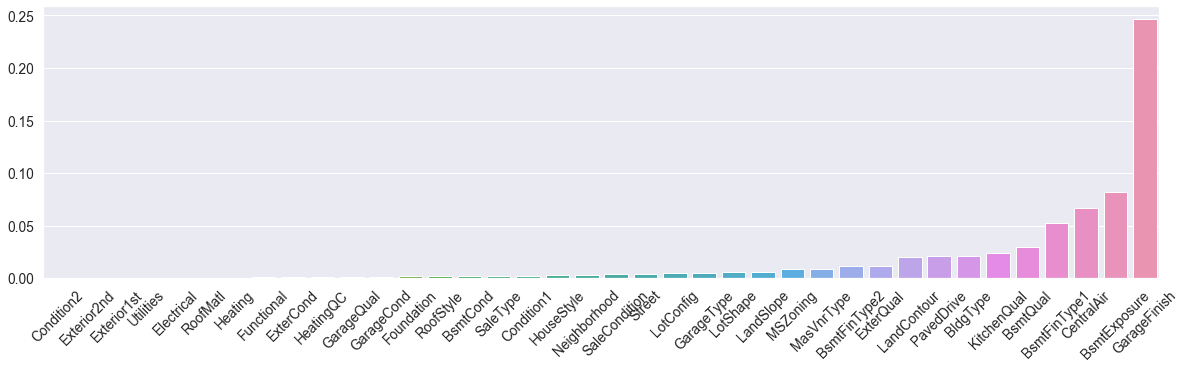

In [439]:
min_frequency = pd.Series(index=cat_candidates)
for col in cat_candidates:
    min_frequency.loc[col] = combined.loc[:,col].value_counts().min() / combined.shape[0]
min_frequency = min_frequency.sort_values()

plt.figure(figsize=(20,5))
sns.barplot(x=min_frequency.index, y=min_frequency.values)
plt.xticks(rotation=45);

In [440]:
min_frequency = pd.Series(index=cat_candidates)
for col in cat_candidates:
    min_frequency.loc[col] = combined_3.loc[:,col].value_counts().min() / combined_3.shape[0]
min_frequency = min_frequency.sort_values()

plt.figure(figsize=(20,5))
sns.barplot(x=min_frequency.index, y=min_frequency.values)
plt.xticks(rotation=45);

KeyError: 'Street'

In [441]:
num_candidates = combined.dtypes[combined.dtypes!="object"].index.values
num_candidates, len(num_candidates)

(array(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
        'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
        'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
        'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
        'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
        'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
        'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
       dtype=object), 35)

In [442]:
num_candidates_3 = combined_3.dtypes[combined.dtypes!="object"].index.values
num_candidates_3, len(num_candidates_3)

(array(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
        'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
        'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
        'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
        'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
        'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
        'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
       dtype=object), 35)

In [443]:
combined.loc[:, num_candidates].head(10)

MSSubClass  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
Id                                                                           
1           60     8450            7            5       2003          2003   
2           20     9600            6            8       1976          1976   
3           60    11250            7            5       2001          2002   
4           70     9550            7            5       1915          1970   
5           60    14260            8            5       2000          2000   
6           50    14115            5            5       1993          1995   
7           20    10084            8            5       2004          2005   
8           60    10382            7            6       1973          1973   
9           50     6120            7            5       1931          1950   
10         190     7420            5            6       1939          1950   

    MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  GarageArea  \
Id                                                 ...               
1        196.0       706.0         0.0      150.0  ...       548.0   
2          0.0       978.0         0.0      284.0  ...       460.0   
3        162.0       486.0         0.0      434.0  ...       608.0   
4          0.0       216.0         0.0      540.0  ...       642.0   
5        350.0       655.0         0.0      490.0  ...       836.0   
6          0.0       732.0         0.0       64.0  ...       480.0   
7        186.0      1369.0         0.0      317.0  ...       636.0   
8        240.0       859.0        32.0      216.0  ...       484.0   
9          0.0         0.0         0.0      952.0  ...       468.0   
10         0.0       851.0         0.0      140.0  ...       205.0   

    WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
Id                                                                             
1            0           61              0          0            0         0   
2          298            0              0          0            0         0   
3            0           42              0          0            0         0   
4            0           35            272          0            0         0   
5          192           84              0          0            0         0   
6           40           30              0        320            0         0   
7          255           57              0          0            0         0   
8          235          204            228          0            0         0   
9           90            0            205          0            0         0   
10           0            4              0          0            0         0   

    MiscVal  MoSold  YrSold  
Id                           
1         0       2    2008  
2         0       5    2007  
3         0       9    2008  
4         0       2    2006  
5         0      12    2008  
6       700      10    2009  
7         0       8    2007  
8       350      11    2009  
9         0       4    2008  
10        0       1    2008  

[10 rows x 35 columns]

In [444]:
next_cat_candidates = [
    "OverallQual", "OverallCond", "MSSubClass", 'BsmtFullBath',
    'BsmtHalfBath','FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
    'TotRmsAbvGrd', 'Fireplaces', 'GarageCars'
]
len(next_cat_candidates), len(cat_candidates)

(12, 38)

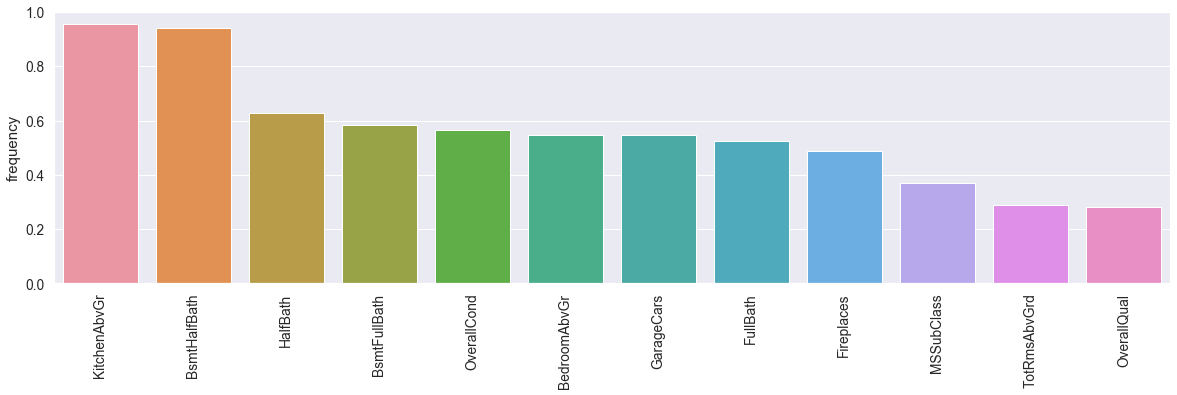

In [445]:
frequencies = []
for col in next_cat_candidates:
    overall_freq = combined.loc[:, col].value_counts().max() / combined.shape[0]
    frequencies.append([col, overall_freq])

frequencies = np.array(frequencies)
freq_df = pd.DataFrame(index=frequencies[:,0], data=frequencies[:,1], columns=["frequency"])
sorted_freq = freq_df.frequency.sort_values(ascending=False)

plt.figure(figsize=(20,5))
sns.barplot(x=sorted_freq.index[0:30], y=sorted_freq[0:30].astype(np.float))
plt.xticks(rotation=90);

In [446]:
cats_to_drop = ["KitchenAbvGr", "BsmtHalfBath"]


In [447]:
combined = combined.drop(cats_to_drop, axis=1)


In [448]:
combined_1 = combined_1.drop(cats_to_drop, axis=1)

In [449]:
combined_2 = combined_2.drop(cats_to_drop, axis=1)

In [450]:
combined_3 = combined_3.drop(cats_to_drop, axis=1)

In [451]:
combined.shape , combined_1.shape , combined_2.shape, combined_3.shape

((2919, 71), (2919, 71), (2919, 60), (2919, 60))

In [452]:
combined.dtypes['LotArea']

dtype('int64')

In [453]:
def checkFeatures(df):
    x=0
    y=0
    for col in combined.columns:
        if combined.dtypes[col]=='object':
            x = x+1
        else:
            y = y+1
    return print('DF has',x,'object(cat), and',y,'another types(num)')
        

In [454]:
checkFeatures(combined)

DF has 38 object(cat), and 33 another types(num)


In [455]:
checkFeatures(combined_1)

DF has 38 object(cat), and 33 another types(num)


In [389]:
for col in cat_candidates:
    combined[col] = combined[col].astype("object")

In [391]:
for col in cat_candidates:
    combined_1[col] = combined_1[col].astype("object")

In [456]:
combined.shape ,combined_1.shape

((2919, 71), (2919, 71))

In [393]:
checkFeatures(combined), checkFeatures(combined_1)

DF has 38 object(cat), and 33 another types(num)
DF has 38 object(cat), and 33 another types(num)


(None, None)

In [403]:
next_cat_candidates = [
    "OverallQual", "OverallCond", "MSSubClass", 'BsmtFullBath',
    'FullBath', 'HalfBath', 'BedroomAbvGr',
    'TotRmsAbvGrd', 'Fireplaces', 'GarageCars'
]
len(next_cat_candidates), len(cat_candidates)

(10, 38)

In [463]:
for col in next_cat_candidates:
    if col in combined_1.columns:
        combined_1[col] = combined_2[col].astype("object")

In [464]:
for col in next_cat_candidates:
    if col in combined_3.columns:
        combined_3[col] = combined_3[col].astype("object")

In [465]:
checkFeatures(combined), checkFeatures(combined_1), checkFeatures(combined_2), checkFeatures(combined_3)

DF has 38 object(cat), and 33 another types(num)
DF has 38 object(cat), and 33 another types(num)
DF has 38 object(cat), and 33 another types(num)
DF has 38 object(cat), and 33 another types(num)


(None, None, None, None)

In [466]:
num_candidates = combined.dtypes[combined.dtypes!="object"].index.values
num_candidates_1 = combined_1.dtypes[combined_1.dtypes!="object"].index.values
num_candidates_2 = combined_2.dtypes[combined_2.dtypes!="object"].index.values
num_candidates_3 = combined_3.dtypes[combined_3.dtypes!="object"].index.values
len(num_candidates), len(num_candidates_1), len(num_candidates_2), len(num_candidates_3)

(33, 23, 33, 23)

In [467]:
num_candidates

array(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'], dtype=object)

In [468]:
cat_candidates

array(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'], dtype=object)

In [469]:
len(num_candidates), len(cat_candidates)

(33, 38)

In [470]:
train.shape, train_1.shape, test.shape, test_1.shape

((1460, 80), (1460, 74), (1459, 79), (1459, 73))

In [471]:
train_1.isnull().sum().sort_values(ascending=False).head(20)

GarageType      81
GarageYrBlt     81
GarageFinish    81
GarageQual      81
GarageCond      81
BsmtFinType2    38
BsmtExposure    38
BsmtFinType1    37
BsmtCond        37
BsmtQual        37
MasVnrType       8
MasVnrArea       8
Electrical       1
YearRemodAdd     0
ExterQual        0
ExterCond        0
Exterior2nd      0
Exterior1st      0
Foundation       0
BsmtFinSF1       0
dtype: int64

In [472]:
test_1.isnull().sum().sort_values(ascending=False).head(20)

GarageQual      78
GarageCond      78
GarageYrBlt     78
GarageFinish    78
GarageType      76
BsmtCond        45
BsmtQual        44
BsmtExposure    44
BsmtFinType1    42
BsmtFinType2    42
MasVnrType      16
MasVnrArea      15
MSZoning         4
Functional       2
BsmtHalfBath     2
BsmtFullBath     2
Utilities        2
KitchenQual      1
Exterior2nd      1
SaleType         1
dtype: int64

In [473]:
def impute_na_trees(df, col):
    if df[col].dtype == "object":
        df[col] = df[col].fillna("Unknown")
        df[col] = df[col].astype("object")
    else:
        df[col] = df[col].fillna(-99999)
    return df

def impute_na_no_trees(df, col):
    if df[col].dtype == "object":
        df[col] = df[col].fillna("Unknown")
    else:
        df[col] = df[col].fillna("median")
    return df

In [474]:
#Обработка плохих значений

In [475]:
for col in combined.columns:
    combined_good = impute_na_trees(combined, col)
    
    
for col in combined_1.columns:
    combined_good_1 = impute_na_trees(combined_1, col)
    
    
for col in combined_2.columns:
    combined_good_2 = impute_na_trees(combined_2, col)
    
for col in combined_3.columns:
    combined_good_3 = impute_na_trees(combined_3, col)
    

In [476]:
combined.shape ,combined_1.shape, combined_2.shape, combined_3.shape

((2919, 71), (2919, 71), (2919, 60), (2919, 60))

In [477]:
combined_good.shape ,combined_good_1.shape, combined_good_2.shape, combined_good_3.shape

((2919, 71), (2919, 71), (2919, 60), (2919, 60))

In [205]:
num_candidates = combined.dtypes[combined.dtypes!="object"].index.values
num_candidates_1 = combined_1.dtypes[combined_1.dtypes!="object"].index.values
num_candidates_2 = combined_2.dtypes[combined_2.dtypes!="object"].index.values
num_candidates_3 = combined_3.dtypes[combined_3.dtypes!="object"].index.values
len(num_candidates), len(num_candidates_1), len(num_candidates_2), len(num_candidates_3)

(36, 25, 34, 24)

In [479]:
caat = []
x=0

for col in combined_1.columns:
    if col in num_candidates:
        x=x+1
        #print(x)
    else:
        caat.append(col)
        
cat_candi = np.array(caat, dtype="object")

type(caat), type(cat_candidates), type(cat_candi)


(list, numpy.ndarray, numpy.ndarray)

In [480]:
def get_categor(df, num_array):
    caat = []
    x=0
    y=0
    for col in df.columns:
        if col in num_array:
            x=x+1
            #print(x)
        else:
            caat.append(col)
            y=y+1
    cat_array = np.array(caat, dtype="object")
    print('x-',x,'y-',y)
    return cat_array

    

In [481]:
cat_candidates = get_categor(df=combined, num_array=num_candidates)

x- 33 y- 38


In [482]:
combined.shape

(2919, 71)

In [483]:
cat_candidates_1 = get_categor(df=combined_1, num_array=num_candidates)

x- 33 y- 38


In [484]:
cat_candidates_2 = get_categor(df=combined_2, num_array=num_candidates)


x- 33 y- 27


In [485]:
cat_candidates_3 = get_categor(df=combined_3, num_array=num_candidates)

x- 33 y- 27


In [488]:
len(cat_candidates), len(cat_candidates_1), len(cat_candidates_2), len(cat_candidates_3)

(38, 38, 27, 27)

In [489]:
len(num_candidates), len(num_candidates_1), len(num_candidates_2), len(num_candidates_3)

(33, 23, 33, 23)

In [490]:
len(cat_candidates)+len(num_candidates), len(cat_candidates_1)+len(num_candidates_1), len(cat_candidates_2)+len(num_candidates_2), len(cat_candidates_3)+len(num_candidates_3) 

(71, 61, 60, 50)

In [491]:
combined.shape[1], combined_1.shape[1], combined_2.shape[1], combined_3.shape[1]

(71, 71, 60, 60)

In [217]:
cat_candi.astype("object")
cat_candi.dtype

dtype('O')

In [218]:
cat_candidates

array(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'], dtype=object)

In [219]:
cat_candi

array(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
       'GarageType', 'GarageFinish', 'GarageQual', 'SaleType',
       'SaleCondition'], dtype=object)

In [220]:
len(combined_1.dtypes[combined_1.dtypes=="object"].index.values)

38

In [221]:
cat_candidates = combined.dtypes[combined.dtypes=="object"].index.values
cat_candidates_1 = combined_1.dtypes[combined_1.dtypes=="object"].index.values
cat_candidates_2 = combined_2.dtypes[combined_2.dtypes=="object"].index.values
cat_candidates_3 = combined_3.dtypes[combined_3.dtypes=="object"].index.values

len(cat_candidates), len(cat_candidates_1), len(cat_candidates_2), len(cat_candidates_3)

(38, 38, 38, 38)

In [222]:
diff = []
x =0 
y = 0
for col in combined_good.columns:
    if col in combined_good_2.columns:
        x = x+1
        
    else:
        print('Find diferense - ', col)
        diff.append(col)
        y=y+1

print(x,y)

Find diferense -  BsmtHalfBath
Find diferense -  KitchenAbvGr
72 2


In [223]:
diff, cat_candidates_2

(['BsmtHalfBath', 'KitchenAbvGr'],
 array(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
        'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
        'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
        'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
        'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
        'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
        'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
        'PavedDrive', 'SaleType', 'SaleCondition'], dtype=object))

In [224]:
type(diff), type(cat_candidates_2)

(list, numpy.ndarray)

In [225]:
if diff in cat_candidates_2:
    print('yes')




In [226]:
combined.isnull().sum().sum(), combined_1.isnull().sum().sum(), combined_2.isnull().sum().sum(), combined_3.isnull().sum().sum()

(0, 0, 0, 0)

In [227]:
train_1.shape

(1460, 75)

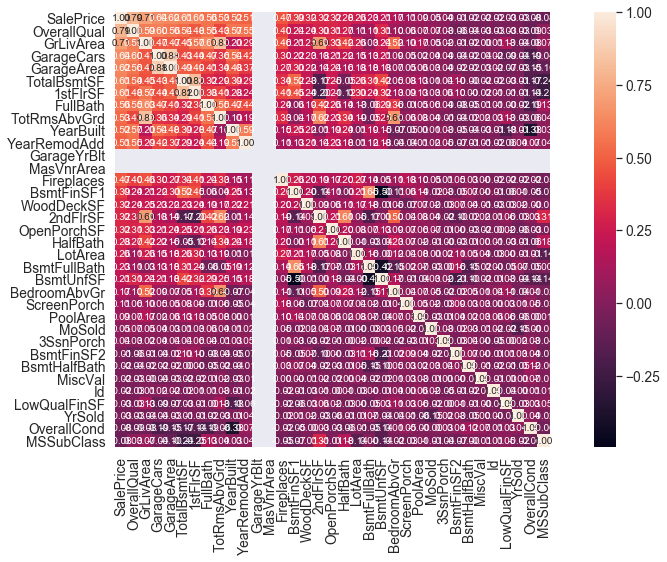

In [228]:
#saleprice correlation matrix
k = 35 #number of variables for heatmap
plt.figure(figsize=(16,8))
corrmat = train_1.corr()
# picking the top 15 correlated features
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [229]:
train.shape, test.shape, train_1.shape, test_1.shape

((1460, 81), (1459, 80), (1460, 75), (1459, 74))

In [230]:
traindf = combined.iloc[0:train.shape[0]].copy()
traindf.loc[:, "target"] = np.log(train.SalePrice+1)
testdf = combined.iloc[train.shape[0]::].copy()

In [231]:
traindf.shape, testdf.shape

((1460, 75), (1459, 74))

In [232]:
traindf_1 = combined_1.iloc[0:train_1.shape[0]].copy()
traindf_1.loc[:, "target"] = np.log(train.SalePrice+1)
testdf_1 = combined_1.iloc[train.shape[0]::].copy()

traindf_2 = combined_2.iloc[0:train.shape[0]].copy()
traindf_2.loc[:, "target"] = np.log(train.SalePrice+1)
testdf_2 = combined_2.iloc[train.shape[0]::].copy()

traindf_3 = combined_3.iloc[0:train.shape[0]].copy()
traindf_3.loc[:, "target"] = np.log(train.SalePrice+1)
testdf_3 = combined_3.iloc[train.shape[0]::].copy()

In [233]:
traindf_1.shape, testdf_1.shape, traindf_2.shape, testdf_2.shape, traindf_3.shape, testdf_3.shape

((1460, 64), (1459, 63), (1460, 73), (1459, 72), (1460, 63), (1459, 62))

In [234]:
b = np.array([1,2,3,4,5])

In [235]:
a = np.log(b+1)
a

array([0.69314718, 1.09861229, 1.38629436, 1.60943791, 1.79175947])

In [236]:
c = np.exp(a)-1
c

array([1., 2., 3., 4., 5.])

# Начинаем обучение

In [237]:
traindf.head()

Id  MSSubClass MSZoning  LotArea Street LotShape LandContour Utilities  \
0   1          60       RL     8450   Pave      Reg         Lvl    AllPub   
1   2          20       RL     9600   Pave      Reg         Lvl    AllPub   
2   3          60       RL    11250   Pave      IR1         Lvl    AllPub   
3   4          70       RL     9550   Pave      IR1         Lvl    AllPub   
4   5          60       RL    14260   Pave      IR1         Lvl    AllPub   

  LotConfig LandSlope  ... EnclosedPorch 3SsnPorch ScreenPorch PoolArea  \
0    Inside       Gtl  ...             0         0           0        0   
1       FR2       Gtl  ...             0         0           0        0   
2    Inside       Gtl  ...             0         0           0        0   
3    Corner       Gtl  ...           272         0           0        0   
4       FR2       Gtl  ...             0         0           0        0   

  MiscVal  MoSold  YrSold  SaleType  SaleCondition     target  
0       0       2    2008        WD         Normal  12.247699  
1       0       5    2007        WD         Normal  12.109016  
2       0       9    2008        WD         Normal  12.317171  
3       0       2    2006        WD        Abnorml  11.849405  
4       0      12    2008        WD         Normal  12.429220  

[5 rows x 75 columns]

In [238]:
traindf.shape

(1460, 75)

In [239]:
y_train = np.exp(traindf['target'])-1
X_train = traindf[num_candidates]
X_test = testdf[num_candidates]

In [240]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [241]:
from sklearn.tree import DecisionTreeRegressor

In [242]:
first_tree = DecisionTreeRegressor( random_state=17)
first_tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=17, splitter='best')

In [243]:
p_test = first_tree.predict(X_test)

In [244]:
submission = pd.read_csv("../data_sorev/sample_submission.csv", index_col=0)
submission.head()

SalePrice
Id                 
1461  169277.052498
1462  187758.393989
1463  183583.683570
1464  179317.477511
1465  150730.079977

In [245]:
len(p_test), submission.shape

(1459, (1459, 1))

In [246]:
for i in range(p_test.shape[0]):
    submission.loc[1460+i] = p_test[i]
    #print("i = ", i ,"predict = ", p_test[i])

In [247]:
submission.head(), submission.shape

(      SalePrice
 Id             
 1461   155000.0
 1462   223500.0
 1463   178000.0
 1464   213500.0
 1465   165600.0, (1460, 1))

In [499]:
submission.to_csv("submission_first_tree.csv")

In [518]:
from sklearn.model_selection import train_test_split, cross_val_score
np.mean(cross_val_score(first_tree, X_train, y_train, cv=6))

0.7099941744381701

In [507]:
from sklearn import linear_model

In [509]:
first_liner = linear_model.LinearRegression()

In [510]:
first_liner.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [511]:
p_test = first_liner.predict(X_test)

In [519]:
np.mean(cross_val_score(first_liner, X_train, y_train, cv=6))

0.7613033933563481

In [514]:
def makeSub(answer, model):
    stat = "no"
    submission = pd.read_csv("../data_sorev/sample_submission.csv", index_col=0)
    for i in range(answer.shape[0]):
        submission.loc[1460+i] = answer[i]
    submission.to_csv("submission_" + str(model) + ".csv")
    return "ok"
        
        
        
    

In [515]:
makeSub(answer=p_test,model='linearReg')

'ok'

In [529]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

In [248]:
from catboost import CatBoostClassifier

In [249]:
ctb = CatBoostRegressor(random_seed=17, task_type="GPU", iterations=4000)

In [250]:
ctb1 = CatBoostRegressor(random_seed=17, iterations=8000)

In [251]:
y_train = train['SalePrice']
X_train = traindf.drop('target', axis=1)
X_test = testdf

In [252]:
X_train.shape, X_test.shape, y_train.shape

((1460, 74), (1459, 74), (1460,))

In [253]:
train_df_part, valid_df, y_train_part, y_valid = train_test_split(traindf, y_train, 
                                                                  test_size=.3, 
                                                                  random_state=17)

In [254]:
cat_candidates.shape

(38,)

In [255]:
y_train.shape

(1460,)

In [256]:
%%time
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

NameError: name 'StratifiedKFold' is not defined

In [257]:
from sklearn.utils.multiclass import type_of_target
type_of_target(y_train)

'multiclass'

In [258]:
type_of_target(y_train_part), type_of_target(y_valid)

('multiclass', 'multiclass')

In [259]:
y_train.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [260]:
y_train = train['SalePrice']
X_train = traindf_2.drop('target', axis=1)
X_test = testdf_2

In [261]:
%%time
ctb.fit(X_train, y_train,
        cat_features=cat_candidates);

0:	learn: 77819.9485607	total: 49.3ms	remaining: 3m 17s
1:	learn: 76247.6770514	total: 99.8ms	remaining: 3m 19s
2:	learn: 74839.8981811	total: 147ms	remaining: 3m 16s
3:	learn: 73433.9512190	total: 194ms	remaining: 3m 13s
4:	learn: 72066.5547225	total: 239ms	remaining: 3m 10s
5:	learn: 70675.7270853	total: 285ms	remaining: 3m 9s
6:	learn: 69419.1829210	total: 335ms	remaining: 3m 11s
7:	learn: 68055.3769860	total: 380ms	remaining: 3m 9s
8:	learn: 66722.7266037	total: 427ms	remaining: 3m 9s
9:	learn: 65600.8117878	total: 467ms	remaining: 3m 6s
10:	learn: 64457.5122797	total: 506ms	remaining: 3m 3s
11:	learn: 63378.2765504	total: 550ms	remaining: 3m 2s
12:	learn: 62301.1129289	total: 590ms	remaining: 3m
13:	learn: 61187.5023472	total: 639ms	remaining: 3m 1s
14:	learn: 60154.6260730	total: 686ms	remaining: 3m 2s
15:	learn: 59180.5414655	total: 732ms	remaining: 3m 2s
16:	learn: 58198.6904648	total: 784ms	remaining: 3m 3s
17:	learn: 57231.4825670	total: 825ms	remaining: 3m 2s
18:	learn: 5635

149:	learn: 23607.0598811	total: 8.54s	remaining: 3m 42s
150:	learn: 23550.7611348	total: 8.59s	remaining: 3m 42s
151:	learn: 23508.6705655	total: 8.64s	remaining: 3m 41s
152:	learn: 23483.8790906	total: 8.69s	remaining: 3m 41s
153:	learn: 23452.1365859	total: 8.74s	remaining: 3m 41s
154:	learn: 23376.4185349	total: 8.79s	remaining: 3m 41s
155:	learn: 23322.8254403	total: 8.86s	remaining: 3m 41s
156:	learn: 23286.9806415	total: 8.86s	remaining: 3m 41s
157:	learn: 23257.7806011	total: 8.9s	remaining: 3m 40s
158:	learn: 23222.2132977	total: 9.76s	remaining: 4m
159:	learn: 23187.7974900	total: 9.8s	remaining: 3m 59s
160:	learn: 23169.8802537	total: 9.85s	remaining: 3m 59s
161:	learn: 23141.6933824	total: 9.89s	remaining: 3m 58s
162:	learn: 23118.1898822	total: 9.94s	remaining: 3m 58s
163:	learn: 23098.8836592	total: 9.99s	remaining: 3m 58s
164:	learn: 23043.0137451	total: 10s	remaining: 3m 57s
165:	learn: 23020.3220686	total: 10s	remaining: 3m 57s
166:	learn: 22970.8658972	total: 10.1s	re

296:	learn: 20318.4477457	total: 20.7s	remaining: 4m 24s
297:	learn: 20294.5422061	total: 20.8s	remaining: 4m 24s
298:	learn: 20280.1990793	total: 20.8s	remaining: 4m 23s
299:	learn: 20253.6987418	total: 20.9s	remaining: 4m 23s
300:	learn: 20249.7866469	total: 20.9s	remaining: 4m 22s
301:	learn: 20242.9403246	total: 20.9s	remaining: 4m 22s
302:	learn: 20233.2599574	total: 21s	remaining: 4m 22s
303:	learn: 20221.7415073	total: 21s	remaining: 4m 21s
304:	learn: 20216.3556213	total: 21.1s	remaining: 4m 21s
305:	learn: 20178.3716942	total: 21.1s	remaining: 4m 21s
306:	learn: 20171.1328426	total: 21.2s	remaining: 4m 20s
307:	learn: 20167.6354143	total: 21.2s	remaining: 4m 20s
308:	learn: 20157.8654404	total: 21.3s	remaining: 4m 20s
309:	learn: 20146.4977267	total: 21.3s	remaining: 4m 19s
310:	learn: 20144.5313649	total: 21.4s	remaining: 4m 19s
311:	learn: 20133.5072719	total: 21.4s	remaining: 4m 19s
312:	learn: 20120.4437327	total: 21.5s	remaining: 4m 18s
313:	learn: 20098.4646949	total: 21

444:	learn: 18784.0091853	total: 30.9s	remaining: 4m 13s
445:	learn: 18781.6719381	total: 30.9s	remaining: 4m 13s
446:	learn: 18779.0607121	total: 31.7s	remaining: 4m 19s
447:	learn: 18769.4235198	total: 31.8s	remaining: 4m 19s
448:	learn: 18767.0132990	total: 31.9s	remaining: 4m 18s
449:	learn: 18763.8276972	total: 31.9s	remaining: 4m 18s
450:	learn: 18762.7015142	total: 32s	remaining: 4m 18s
451:	learn: 18760.0553459	total: 32s	remaining: 4m 18s
452:	learn: 18754.4028756	total: 32s	remaining: 4m 17s
453:	learn: 18749.0707142	total: 32.1s	remaining: 4m 17s
454:	learn: 18723.7219108	total: 32.1s	remaining: 4m 17s
455:	learn: 18722.3259906	total: 32.1s	remaining: 4m 17s
456:	learn: 18716.0745398	total: 33s	remaining: 4m 23s
457:	learn: 18714.6054937	total: 33.1s	remaining: 4m 23s
458:	learn: 18702.1601448	total: 33.1s	remaining: 4m 22s
459:	learn: 18696.0225977	total: 33.2s	remaining: 4m 22s
460:	learn: 18690.4294161	total: 33.2s	remaining: 4m 22s
461:	learn: 18687.5280106	total: 33.2s	

593:	learn: 17916.3650325	total: 42.1s	remaining: 4m 9s
594:	learn: 17908.5489832	total: 42.2s	remaining: 4m 8s
595:	learn: 17899.9671979	total: 42.2s	remaining: 4m 8s
596:	learn: 17892.0260718	total: 42.3s	remaining: 4m 8s
597:	learn: 17889.4273844	total: 42.3s	remaining: 4m 8s
598:	learn: 17884.4842576	total: 43.1s	remaining: 4m 12s
599:	learn: 17881.6190153	total: 43.2s	remaining: 4m 12s
600:	learn: 17879.3207165	total: 43.2s	remaining: 4m 12s
601:	learn: 17872.1892142	total: 43.2s	remaining: 4m 11s
602:	learn: 17862.1362462	total: 44.1s	remaining: 4m 16s
603:	learn: 17861.3735323	total: 44.1s	remaining: 4m 16s
604:	learn: 17852.6219813	total: 44.2s	remaining: 4m 15s
605:	learn: 17850.5915313	total: 44.2s	remaining: 4m 15s
606:	learn: 17838.1378720	total: 44.3s	remaining: 4m 15s
607:	learn: 17824.1979281	total: 44.3s	remaining: 4m 15s
608:	learn: 17793.1781614	total: 44.4s	remaining: 4m 14s
609:	learn: 17792.0908246	total: 44.4s	remaining: 4m 14s
610:	learn: 17790.7864374	total: 44.

739:	learn: 17100.9458119	total: 51.6s	remaining: 3m 54s
740:	learn: 17099.2211887	total: 51.7s	remaining: 3m 53s
741:	learn: 17098.1323815	total: 51.7s	remaining: 3m 53s
742:	learn: 17096.7107243	total: 52.5s	remaining: 3m 57s
743:	learn: 17092.2178777	total: 52.6s	remaining: 3m 57s
744:	learn: 17087.7625965	total: 52.6s	remaining: 3m 56s
745:	learn: 17076.2430849	total: 52.7s	remaining: 3m 56s
746:	learn: 17073.4052085	total: 52.7s	remaining: 3m 56s
747:	learn: 17057.1141120	total: 52.8s	remaining: 3m 56s
748:	learn: 17052.6641370	total: 52.8s	remaining: 3m 56s
749:	learn: 17048.5263227	total: 52.8s	remaining: 3m 55s
750:	learn: 17045.5521625	total: 52.9s	remaining: 3m 55s
751:	learn: 17043.9970719	total: 52.9s	remaining: 3m 55s
752:	learn: 17039.2282081	total: 52.9s	remaining: 3m 55s
753:	learn: 17031.2072909	total: 53.8s	remaining: 3m 58s
754:	learn: 17030.7658200	total: 53.8s	remaining: 3m 58s
755:	learn: 17029.1092137	total: 53.9s	remaining: 3m 58s
756:	learn: 17025.6043739	total

884:	learn: 16555.6108378	total: 1m	remaining: 3m 37s
885:	learn: 16548.6202393	total: 1m	remaining: 3m 37s
886:	learn: 16544.4879502	total: 1m	remaining: 3m 37s
887:	learn: 16531.5975026	total: 1m	remaining: 3m 36s
888:	learn: 16520.3735379	total: 1m	remaining: 3m 36s
889:	learn: 16517.9564917	total: 1m	remaining: 3m 36s
890:	learn: 16516.5392508	total: 1m	remaining: 3m 36s
891:	learn: 16512.7013550	total: 1m	remaining: 3m 36s
892:	learn: 16512.3289338	total: 1m	remaining: 3m 36s
893:	learn: 16508.9835622	total: 1m	remaining: 3m 35s
894:	learn: 16505.7993242	total: 1m	remaining: 3m 35s
895:	learn: 16504.1648183	total: 1m	remaining: 3m 35s
896:	learn: 16502.3315859	total: 1m	remaining: 3m 35s
897:	learn: 16502.0527753	total: 1m	remaining: 3m 35s
898:	learn: 16500.3410469	total: 1m	remaining: 3m 34s
899:	learn: 16499.5895169	total: 1m	remaining: 3m 34s
900:	learn: 16499.2072776	total: 1m	remaining: 3m 34s
901:	learn: 16495.8680887	total: 1m	remaining: 3m 34s
902:	learn: 16493.4841922	to

1029:	learn: 16120.9346559	total: 1m 8s	remaining: 3m 22s
1030:	learn: 16117.6048256	total: 1m 8s	remaining: 3m 22s
1031:	learn: 16116.9398911	total: 1m 8s	remaining: 3m 22s
1032:	learn: 16115.6879293	total: 1m 8s	remaining: 3m 22s
1033:	learn: 16114.9525828	total: 1m 8s	remaining: 3m 22s
1034:	learn: 16112.9100095	total: 1m 8s	remaining: 3m 22s
1035:	learn: 16110.8184192	total: 1m 8s	remaining: 3m 22s
1036:	learn: 16109.1180620	total: 1m 8s	remaining: 3m 21s
1037:	learn: 16108.3677858	total: 1m 8s	remaining: 3m 21s
1038:	learn: 16103.4828218	total: 1m 8s	remaining: 3m 21s
1039:	learn: 16102.0339789	total: 1m 8s	remaining: 3m 21s
1040:	learn: 16101.6743613	total: 1m 9s	remaining: 3m 21s
1041:	learn: 16100.8157071	total: 1m 9s	remaining: 3m 21s
1042:	learn: 16099.1080199	total: 1m 9s	remaining: 3m 21s
1043:	learn: 16094.7766522	total: 1m 9s	remaining: 3m 20s
1044:	learn: 16094.1860793	total: 1m 9s	remaining: 3m 20s
1045:	learn: 16092.2768536	total: 1m 9s	remaining: 3m 20s
1046:	learn: 1

1170:	learn: 15863.3514219	total: 1m 16s	remaining: 3m 8s
1171:	learn: 15862.6439946	total: 1m 16s	remaining: 3m 8s
1172:	learn: 15862.4204410	total: 1m 16s	remaining: 3m 8s
1173:	learn: 15860.5477022	total: 1m 16s	remaining: 3m 10s
1174:	learn: 15859.7113719	total: 1m 17s	remaining: 3m 10s
1175:	learn: 15859.1728990	total: 1m 17s	remaining: 3m 9s
1176:	learn: 15857.9083711	total: 1m 17s	remaining: 3m 9s
1177:	learn: 15845.6987563	total: 1m 17s	remaining: 3m 9s
1178:	learn: 15844.3701181	total: 1m 17s	remaining: 3m 9s
1179:	learn: 15843.3650667	total: 1m 17s	remaining: 3m 9s
1180:	learn: 15842.3273674	total: 1m 17s	remaining: 3m 9s
1181:	learn: 15842.0114400	total: 1m 17s	remaining: 3m 9s
1182:	learn: 15841.5361203	total: 1m 17s	remaining: 3m 9s
1183:	learn: 15841.2718903	total: 1m 17s	remaining: 3m 8s
1184:	learn: 15838.3466468	total: 1m 17s	remaining: 3m 8s
1185:	learn: 15836.2882381	total: 1m 17s	remaining: 3m 8s
1186:	learn: 15829.4911093	total: 1m 17s	remaining: 3m 8s
1187:	learn:

1312:	learn: 15559.0103147	total: 1m 23s	remaining: 2m 55s
1313:	learn: 15557.4393555	total: 1m 23s	remaining: 2m 55s
1314:	learn: 15550.4799302	total: 1m 23s	remaining: 2m 54s
1315:	learn: 15548.3466028	total: 1m 23s	remaining: 2m 54s
1316:	learn: 15546.8777855	total: 1m 23s	remaining: 2m 54s
1317:	learn: 15539.1402043	total: 1m 23s	remaining: 2m 54s
1318:	learn: 15538.4613487	total: 1m 23s	remaining: 2m 54s
1319:	learn: 15536.8904786	total: 1m 23s	remaining: 2m 54s
1320:	learn: 15536.6716275	total: 1m 23s	remaining: 2m 54s
1321:	learn: 15536.4751645	total: 1m 23s	remaining: 2m 54s
1322:	learn: 15536.1169021	total: 1m 23s	remaining: 2m 54s
1323:	learn: 15534.8007945	total: 1m 24s	remaining: 2m 53s
1324:	learn: 15534.2286647	total: 1m 24s	remaining: 2m 53s
1325:	learn: 15534.1094684	total: 1m 24s	remaining: 2m 53s
1326:	learn: 15533.0626683	total: 1m 24s	remaining: 2m 53s
1327:	learn: 15531.9283747	total: 1m 24s	remaining: 2m 53s
1328:	learn: 15530.1863140	total: 1m 24s	remaining: 2m 5

1455:	learn: 15264.2127437	total: 1m 32s	remaining: 2m 45s
1456:	learn: 15259.6348372	total: 1m 32s	remaining: 2m 45s
1457:	learn: 15258.0234932	total: 1m 32s	remaining: 2m 45s
1458:	learn: 15257.4402492	total: 1m 32s	remaining: 2m 45s
1459:	learn: 15256.3869703	total: 1m 32s	remaining: 2m 45s
1460:	learn: 15255.5969633	total: 1m 32s	remaining: 2m 45s
1461:	learn: 15255.3203776	total: 1m 32s	remaining: 2m 44s
1462:	learn: 15246.9027132	total: 1m 32s	remaining: 2m 44s
1463:	learn: 15246.7746464	total: 1m 32s	remaining: 2m 44s
1464:	learn: 15246.3742467	total: 1m 32s	remaining: 2m 44s
1465:	learn: 15246.0599551	total: 1m 32s	remaining: 2m 44s
1466:	learn: 15245.7235748	total: 1m 32s	remaining: 2m 44s
1467:	learn: 15237.2667308	total: 1m 32s	remaining: 2m 44s
1468:	learn: 15235.5174942	total: 1m 33s	remaining: 2m 44s
1469:	learn: 15235.4210041	total: 1m 33s	remaining: 2m 44s
1470:	learn: 15235.0527159	total: 1m 33s	remaining: 2m 44s
1471:	learn: 15233.8535076	total: 1m 33s	remaining: 2m 4

1595:	learn: 15034.1084584	total: 1m 39s	remaining: 2m 33s
1596:	learn: 15032.1482040	total: 1m 39s	remaining: 2m 33s
1597:	learn: 15028.4912656	total: 1m 39s	remaining: 2m 33s
1598:	learn: 15028.3538704	total: 1m 39s	remaining: 2m 33s
1599:	learn: 15027.8849252	total: 1m 39s	remaining: 2m 33s
1600:	learn: 15021.9471718	total: 1m 39s	remaining: 2m 33s
1601:	learn: 15021.6095083	total: 1m 39s	remaining: 2m 33s
1602:	learn: 15021.2606311	total: 1m 39s	remaining: 2m 32s
1603:	learn: 15020.8788740	total: 1m 39s	remaining: 2m 32s
1604:	learn: 15020.8146243	total: 1m 39s	remaining: 2m 32s
1605:	learn: 15020.5785417	total: 1m 39s	remaining: 2m 32s
1606:	learn: 15020.3940061	total: 1m 39s	remaining: 2m 32s
1607:	learn: 15019.4473853	total: 1m 40s	remaining: 2m 32s
1608:	learn: 15019.1021938	total: 1m 40s	remaining: 2m 32s
1609:	learn: 15018.4446642	total: 1m 40s	remaining: 2m 32s
1610:	learn: 15014.5751172	total: 1m 40s	remaining: 2m 32s
1611:	learn: 15014.2582156	total: 1m 40s	remaining: 2m 3

1739:	learn: 14814.6414123	total: 1m 45s	remaining: 2m 20s
1740:	learn: 14814.4853689	total: 1m 45s	remaining: 2m 20s
1741:	learn: 14814.0641950	total: 1m 45s	remaining: 2m 20s
1742:	learn: 14813.6634626	total: 1m 46s	remaining: 2m 20s
1743:	learn: 14813.3112031	total: 1m 46s	remaining: 2m 20s
1744:	learn: 14813.1763575	total: 1m 46s	remaining: 2m 20s
1745:	learn: 14812.7892376	total: 1m 46s	remaining: 2m 20s
1746:	learn: 14811.9786016	total: 1m 46s	remaining: 2m 20s
1747:	learn: 14811.6452430	total: 1m 46s	remaining: 2m 19s
1748:	learn: 14810.6261801	total: 1m 46s	remaining: 2m 19s
1749:	learn: 14807.6163150	total: 1m 46s	remaining: 2m 19s
1750:	learn: 14807.3419716	total: 1m 46s	remaining: 2m 19s
1751:	learn: 14807.2404177	total: 1m 46s	remaining: 2m 19s
1752:	learn: 14807.0312450	total: 1m 46s	remaining: 2m 19s
1753:	learn: 14805.8792262	total: 1m 46s	remaining: 2m 19s
1754:	learn: 14797.6882134	total: 1m 46s	remaining: 2m 19s
1755:	learn: 14796.9852005	total: 1m 46s	remaining: 2m 1

1881:	learn: 14688.3463832	total: 1m 52s	remaining: 2m 9s
1882:	learn: 14687.8757508	total: 1m 52s	remaining: 2m 9s
1883:	learn: 14685.8050946	total: 1m 52s	remaining: 2m 9s
1884:	learn: 14684.8598309	total: 1m 52s	remaining: 2m 8s
1885:	learn: 14684.7108145	total: 1m 52s	remaining: 2m 8s
1886:	learn: 14684.6313384	total: 1m 52s	remaining: 2m 8s
1887:	learn: 14684.4250044	total: 1m 52s	remaining: 2m 8s
1888:	learn: 14684.3470552	total: 1m 52s	remaining: 2m 8s
1889:	learn: 14683.9848154	total: 1m 52s	remaining: 2m 8s
1890:	learn: 14683.2419667	total: 1m 52s	remaining: 2m 8s
1891:	learn: 14683.1418474	total: 1m 52s	remaining: 2m 8s
1892:	learn: 14681.0605865	total: 1m 52s	remaining: 2m 8s
1893:	learn: 14679.0929390	total: 1m 52s	remaining: 2m 8s
1894:	learn: 14678.8972301	total: 1m 52s	remaining: 2m 8s
1895:	learn: 14678.8192515	total: 1m 52s	remaining: 2m 7s
1896:	learn: 14678.5700233	total: 1m 52s	remaining: 2m 7s
1897:	learn: 14678.4278237	total: 1m 52s	remaining: 2m 7s
1898:	learn: 1

2024:	learn: 14514.0319310	total: 1m 58s	remaining: 1m 58s
2025:	learn: 14508.3665295	total: 1m 58s	remaining: 1m 58s
2026:	learn: 14508.1221080	total: 1m 58s	remaining: 1m 57s
2027:	learn: 14507.5303745	total: 1m 58s	remaining: 1m 57s
2028:	learn: 14507.4375514	total: 1m 58s	remaining: 1m 57s
2029:	learn: 14507.3888190	total: 1m 58s	remaining: 1m 57s
2030:	learn: 14507.3733484	total: 1m 58s	remaining: 1m 57s
2031:	learn: 14507.2542239	total: 1m 58s	remaining: 1m 57s
2032:	learn: 14507.1536636	total: 1m 58s	remaining: 1m 57s
2033:	learn: 14506.4930422	total: 1m 59s	remaining: 1m 58s
2034:	learn: 14505.4950910	total: 1m 59s	remaining: 1m 58s
2035:	learn: 14505.3070972	total: 1m 59s	remaining: 1m 58s
2036:	learn: 14503.5260635	total: 1m 59s	remaining: 1m 57s
2037:	learn: 14503.5082675	total: 1m 59s	remaining: 1m 57s
2038:	learn: 14503.4424996	total: 1m 59s	remaining: 1m 57s
2039:	learn: 14502.9565817	total: 2m	remaining: 1m 57s
2040:	learn: 14502.7933158	total: 2m	remaining: 1m 57s
2041:

2168:	learn: 14362.1944643	total: 2m 7s	remaining: 1m 49s
2169:	learn: 14362.1382069	total: 2m 7s	remaining: 1m 49s
2170:	learn: 14361.6357873	total: 2m 7s	remaining: 1m 49s
2171:	learn: 14361.3974640	total: 2m 7s	remaining: 1m 49s
2172:	learn: 14360.6340212	total: 2m 7s	remaining: 1m 49s
2173:	learn: 14360.5425929	total: 2m 7s	remaining: 1m 49s
2174:	learn: 14359.7986417	total: 2m 7s	remaining: 1m 49s
2175:	learn: 14358.9092881	total: 2m 7s	remaining: 1m 49s
2176:	learn: 14356.4378777	total: 2m 7s	remaining: 1m 49s
2177:	learn: 14354.2334146	total: 2m 7s	remaining: 1m 49s
2178:	learn: 14353.7346274	total: 2m 7s	remaining: 1m 48s
2179:	learn: 14353.4688089	total: 2m 7s	remaining: 1m 48s
2180:	learn: 14352.5915732	total: 2m 7s	remaining: 1m 48s
2181:	learn: 14352.5493519	total: 2m 7s	remaining: 1m 48s
2182:	learn: 14351.7940395	total: 2m 7s	remaining: 1m 48s
2183:	learn: 14349.4003907	total: 2m 7s	remaining: 1m 48s
2184:	learn: 14349.2846471	total: 2m 8s	remaining: 1m 49s
2185:	learn: 1

2308:	learn: 14204.1340415	total: 2m 14s	remaining: 1m 40s
2309:	learn: 14204.0013132	total: 2m 14s	remaining: 1m 40s
2310:	learn: 14203.9175673	total: 2m 14s	remaining: 1m 40s
2311:	learn: 14203.0848218	total: 2m 14s	remaining: 1m 40s
2312:	learn: 14202.9947496	total: 2m 14s	remaining: 1m 40s
2313:	learn: 14198.2975634	total: 2m 14s	remaining: 1m 40s
2314:	learn: 14196.9933919	total: 2m 14s	remaining: 1m 39s
2315:	learn: 14196.7499333	total: 2m 14s	remaining: 1m 39s
2316:	learn: 14196.6297833	total: 2m 14s	remaining: 1m 39s
2317:	learn: 14195.0740659	total: 2m 14s	remaining: 1m 39s
2318:	learn: 14195.0487683	total: 2m 14s	remaining: 1m 39s
2319:	learn: 14195.0282139	total: 2m 14s	remaining: 1m 39s
2320:	learn: 14193.9878085	total: 2m 14s	remaining: 1m 39s
2321:	learn: 14193.8107106	total: 2m 14s	remaining: 1m 39s
2322:	learn: 14192.1692875	total: 2m 14s	remaining: 1m 39s
2323:	learn: 14191.9036058	total: 2m 14s	remaining: 1m 39s
2324:	learn: 14191.7383429	total: 2m 14s	remaining: 1m 3

2447:	learn: 14075.3399013	total: 2m 22s	remaining: 1m 32s
2448:	learn: 14075.2745246	total: 2m 23s	remaining: 1m 32s
2449:	learn: 14074.2324426	total: 2m 23s	remaining: 1m 32s
2450:	learn: 14073.6017343	total: 2m 23s	remaining: 1m 32s
2451:	learn: 14073.3832522	total: 2m 23s	remaining: 1m 32s
2452:	learn: 14073.2173950	total: 2m 23s	remaining: 1m 32s
2453:	learn: 14072.3920666	total: 2m 23s	remaining: 1m 32s
2454:	learn: 14072.3418277	total: 2m 23s	remaining: 1m 32s
2455:	learn: 14071.1671423	total: 2m 23s	remaining: 1m 32s
2456:	learn: 14067.6696196	total: 2m 23s	remaining: 1m 32s
2457:	learn: 14067.3856320	total: 2m 23s	remaining: 1m 32s
2458:	learn: 14067.3720707	total: 2m 23s	remaining: 1m 32s
2459:	learn: 14064.9475704	total: 2m 23s	remaining: 1m 31s
2460:	learn: 14064.6411872	total: 2m 23s	remaining: 1m 31s
2461:	learn: 14063.9932925	total: 2m 23s	remaining: 1m 31s
2462:	learn: 14063.9773341	total: 2m 23s	remaining: 1m 31s
2463:	learn: 14061.6528033	total: 2m 23s	remaining: 1m 3

2588:	learn: 13933.0058467	total: 2m 30s	remaining: 1m 23s
2589:	learn: 13932.7650241	total: 2m 30s	remaining: 1m 23s
2590:	learn: 13931.2056173	total: 2m 30s	remaining: 1m 23s
2591:	learn: 13931.1017043	total: 2m 30s	remaining: 1m 23s
2592:	learn: 13930.7690165	total: 2m 30s	remaining: 1m 23s
2593:	learn: 13930.6119336	total: 2m 30s	remaining: 1m 23s
2594:	learn: 13929.9715001	total: 2m 30s	remaining: 1m 23s
2595:	learn: 13929.6911502	total: 2m 30s	remaining: 1m 23s
2596:	learn: 13927.4384786	total: 2m 30s	remaining: 1m 23s
2597:	learn: 13912.7089833	total: 2m 30s	remaining: 1m 22s
2598:	learn: 13908.7391643	total: 2m 30s	remaining: 1m 22s
2599:	learn: 13907.0205209	total: 2m 30s	remaining: 1m 22s
2600:	learn: 13906.9624222	total: 2m 30s	remaining: 1m 22s
2601:	learn: 13905.9157972	total: 2m 30s	remaining: 1m 22s
2602:	learn: 13900.9809923	total: 2m 30s	remaining: 1m 22s
2603:	learn: 13900.8841189	total: 2m 30s	remaining: 1m 22s
2604:	learn: 13899.2630044	total: 2m 30s	remaining: 1m 2

2729:	learn: 13759.5216738	total: 2m 39s	remaining: 1m 15s
2730:	learn: 13759.0209018	total: 2m 39s	remaining: 1m 15s
2731:	learn: 13758.5551838	total: 2m 39s	remaining: 1m 15s
2732:	learn: 13758.4108162	total: 2m 39s	remaining: 1m 15s
2733:	learn: 13758.3977659	total: 2m 39s	remaining: 1m 15s
2734:	learn: 13758.3749279	total: 2m 39s	remaining: 1m 15s
2735:	learn: 13758.2207706	total: 2m 40s	remaining: 1m 15s
2736:	learn: 13757.7770489	total: 2m 40s	remaining: 1m 15s
2737:	learn: 13757.4083574	total: 2m 40s	remaining: 1m 15s
2738:	learn: 13757.2403222	total: 2m 40s	remaining: 1m 15s
2739:	learn: 13755.7115968	total: 2m 40s	remaining: 1m 15s
2740:	learn: 13755.2971638	total: 2m 40s	remaining: 1m 15s
2741:	learn: 13755.2294502	total: 2m 40s	remaining: 1m 15s
2742:	learn: 13754.4462319	total: 2m 40s	remaining: 1m 15s
2743:	learn: 13753.6058543	total: 2m 40s	remaining: 1m 15s
2744:	learn: 13753.4443001	total: 2m 40s	remaining: 1m 15s
2745:	learn: 13753.2957991	total: 2m 40s	remaining: 1m 1

2869:	learn: 13638.9855663	total: 2m 49s	remaining: 1m 8s
2870:	learn: 13638.7342039	total: 2m 49s	remaining: 1m 8s
2871:	learn: 13638.6354678	total: 2m 49s	remaining: 1m 8s
2872:	learn: 13636.8930700	total: 2m 49s	remaining: 1m 8s
2873:	learn: 13636.8280601	total: 2m 49s	remaining: 1m 8s
2874:	learn: 13633.8545526	total: 2m 49s	remaining: 1m 7s
2875:	learn: 13632.8186519	total: 2m 49s	remaining: 1m 7s
2876:	learn: 13630.0542183	total: 2m 49s	remaining: 1m 7s
2877:	learn: 13629.8821430	total: 2m 49s	remaining: 1m 7s
2878:	learn: 13629.6153809	total: 2m 49s	remaining: 1m 7s
2879:	learn: 13628.7582485	total: 2m 49s	remaining: 1m 7s
2880:	learn: 13621.5688948	total: 2m 49s	remaining: 1m 7s
2881:	learn: 13621.4638555	total: 2m 49s	remaining: 1m 7s
2882:	learn: 13620.5543049	total: 2m 50s	remaining: 1m 7s
2883:	learn: 13620.3685151	total: 2m 50s	remaining: 1m 7s
2884:	learn: 13620.2457524	total: 2m 50s	remaining: 1m 7s
2885:	learn: 13620.2177393	total: 2m 50s	remaining: 1m 7s
2886:	learn: 1

3015:	learn: 13485.6135038	total: 2m 56s	remaining: 59s
3016:	learn: 13485.4745357	total: 2m 56s	remaining: 59s
3017:	learn: 13485.2960386	total: 2m 56s	remaining: 58.9s
3018:	learn: 13485.2810597	total: 2m 56s	remaining: 58.8s
3019:	learn: 13480.8224390	total: 2m 56s	remaining: 58.7s
3020:	learn: 13480.5223426	total: 2m 56s	remaining: 58.7s
3021:	learn: 13480.1419057	total: 2m 57s	remaining: 58.6s
3022:	learn: 13480.0848808	total: 2m 57s	remaining: 58.5s
3023:	learn: 13478.9430845	total: 2m 57s	remaining: 58.5s
3024:	learn: 13478.1891878	total: 2m 57s	remaining: 58.4s
3025:	learn: 13478.0917734	total: 2m 57s	remaining: 58.3s
3026:	learn: 13477.9652169	total: 2m 58s	remaining: 58.5s
3027:	learn: 13477.8082686	total: 2m 58s	remaining: 58.5s
3028:	learn: 13477.5176805	total: 2m 58s	remaining: 58.4s
3029:	learn: 13477.2399922	total: 2m 58s	remaining: 58.3s
3030:	learn: 13477.0322427	total: 2m 58s	remaining: 58.3s
3031:	learn: 13476.5626088	total: 2m 58s	remaining: 58.2s
3032:	learn: 13473

3164:	learn: 13350.1909491	total: 3m 4s	remaining: 49.9s
3165:	learn: 13350.0686440	total: 3m 4s	remaining: 49.8s
3166:	learn: 13349.0468693	total: 3m 4s	remaining: 49.7s
3167:	learn: 13348.3154810	total: 3m 4s	remaining: 49.7s
3168:	learn: 13348.2414993	total: 3m 5s	remaining: 49.6s
3169:	learn: 13347.8808325	total: 3m 5s	remaining: 49.5s
3170:	learn: 13347.4629848	total: 3m 5s	remaining: 49.5s
3171:	learn: 13347.3705017	total: 3m 5s	remaining: 49.4s
3172:	learn: 13346.6928330	total: 3m 5s	remaining: 49.4s
3173:	learn: 13346.5915160	total: 3m 5s	remaining: 49.3s
3174:	learn: 13344.3610871	total: 3m 5s	remaining: 49.2s
3175:	learn: 13343.7173256	total: 3m 5s	remaining: 49.2s
3176:	learn: 13342.7446865	total: 3m 5s	remaining: 49.1s
3177:	learn: 13341.2950578	total: 3m 5s	remaining: 49s
3178:	learn: 13340.8366278	total: 3m 5s	remaining: 49s
3179:	learn: 13340.3617786	total: 3m 5s	remaining: 48.9s
3180:	learn: 13339.8780796	total: 3m 5s	remaining: 48.8s
3181:	learn: 13338.6813749	total: 3

3312:	learn: 13226.2969340	total: 3m 12s	remaining: 40.7s
3313:	learn: 13225.4696645	total: 3m 12s	remaining: 40.7s
3314:	learn: 13225.2104427	total: 3m 12s	remaining: 40.6s
3315:	learn: 13220.1280760	total: 3m 12s	remaining: 40.5s
3316:	learn: 13219.8763893	total: 3m 12s	remaining: 40.5s
3317:	learn: 13219.6735085	total: 3m 12s	remaining: 40.4s
3318:	learn: 13219.1667174	total: 3m 12s	remaining: 40.3s
3319:	learn: 13217.5715142	total: 3m 12s	remaining: 40.3s
3320:	learn: 13217.4980742	total: 3m 12s	remaining: 40.2s
3321:	learn: 13217.4479820	total: 3m 12s	remaining: 40.1s
3322:	learn: 13217.1881784	total: 3m 12s	remaining: 40.1s
3323:	learn: 13217.0047845	total: 3m 12s	remaining: 40s
3324:	learn: 13216.6328947	total: 3m 12s	remaining: 40s
3325:	learn: 13216.6099697	total: 3m 12s	remaining: 39.9s
3326:	learn: 13216.0266410	total: 3m 12s	remaining: 39.8s
3327:	learn: 13215.9230486	total: 3m 12s	remaining: 39.8s
3328:	learn: 13215.2836451	total: 3m 12s	remaining: 39.7s
3329:	learn: 13215

3459:	learn: 13071.8146497	total: 3m 18s	remaining: 31.7s
3460:	learn: 13071.7283720	total: 3m 18s	remaining: 31.6s
3461:	learn: 13071.6760041	total: 3m 18s	remaining: 31.5s
3462:	learn: 13071.3896942	total: 3m 18s	remaining: 31.5s
3463:	learn: 13069.9310044	total: 3m 18s	remaining: 31.4s
3464:	learn: 13069.8623158	total: 3m 18s	remaining: 31.3s
3465:	learn: 13068.3442047	total: 3m 18s	remaining: 31.3s
3466:	learn: 13068.2729316	total: 3m 18s	remaining: 31.2s
3467:	learn: 13066.9723435	total: 3m 18s	remaining: 31.2s
3468:	learn: 13066.9349856	total: 3m 18s	remaining: 31.2s
3469:	learn: 13066.8946218	total: 3m 18s	remaining: 31s
3470:	learn: 13066.1113679	total: 3m 19s	remaining: 31.1s
3471:	learn: 13065.8146296	total: 3m 19s	remaining: 31s
3472:	learn: 13065.7244473	total: 3m 19s	remaining: 31s
3473:	learn: 13065.4680684	total: 3m 19s	remaining: 30.9s
3474:	learn: 13065.2035248	total: 3m 19s	remaining: 30.9s
3475:	learn: 13065.0244395	total: 3m 19s	remaining: 30.8s
3476:	learn: 13065.0

3606:	learn: 12917.2936001	total: 3m 26s	remaining: 23s
3607:	learn: 12916.2858091	total: 3m 26s	remaining: 22.9s
3608:	learn: 12916.1398466	total: 3m 26s	remaining: 22.9s
3609:	learn: 12915.9400144	total: 3m 26s	remaining: 22.8s
3610:	learn: 12915.2132072	total: 3m 26s	remaining: 22.8s
3611:	learn: 12915.0085816	total: 3m 26s	remaining: 22.7s
3612:	learn: 12915.0033682	total: 3m 26s	remaining: 22.6s
3613:	learn: 12914.8374062	total: 3m 26s	remaining: 22.6s
3614:	learn: 12914.5393643	total: 3m 26s	remaining: 22.5s
3615:	learn: 12914.4820143	total: 3m 26s	remaining: 22.4s
3616:	learn: 12914.4429120	total: 3m 26s	remaining: 22.4s
3617:	learn: 12912.1730327	total: 3m 27s	remaining: 22.3s
3618:	learn: 12911.5329277	total: 3m 27s	remaining: 22.3s
3619:	learn: 12910.2700068	total: 3m 27s	remaining: 22.2s
3620:	learn: 12909.9844636	total: 3m 27s	remaining: 22.1s
3621:	learn: 12909.9701210	total: 3m 27s	remaining: 22.1s
3622:	learn: 12909.9592555	total: 3m 27s	remaining: 22s
3623:	learn: 12909

3750:	learn: 12811.6365736	total: 3m 32s	remaining: 14.4s
3751:	learn: 12810.7772711	total: 3m 32s	remaining: 14.3s
3752:	learn: 12810.7606276	total: 3m 32s	remaining: 14.3s
3753:	learn: 12810.4925762	total: 3m 32s	remaining: 14.2s
3754:	learn: 12810.4846922	total: 3m 32s	remaining: 14.1s
3755:	learn: 12810.4426444	total: 3m 32s	remaining: 14.1s
3756:	learn: 12809.7803730	total: 3m 32s	remaining: 14s
3757:	learn: 12808.9927862	total: 3m 32s	remaining: 14s
3758:	learn: 12808.3834464	total: 3m 32s	remaining: 13.9s
3759:	learn: 12807.5502116	total: 3m 32s	remaining: 13.8s
3760:	learn: 12807.3061888	total: 3m 32s	remaining: 13.8s
3761:	learn: 12806.2560054	total: 3m 32s	remaining: 13.7s
3762:	learn: 12804.7267985	total: 3m 32s	remaining: 13.7s
3763:	learn: 12804.3740472	total: 3m 32s	remaining: 13.6s
3764:	learn: 12800.7508821	total: 3m 32s	remaining: 13.5s
3765:	learn: 12799.4353848	total: 3m 32s	remaining: 13.5s
3766:	learn: 12799.0456631	total: 3m 32s	remaining: 13.4s
3767:	learn: 12798

3895:	learn: 12706.5043458	total: 3m 41s	remaining: 6.04s
3896:	learn: 12706.2835531	total: 3m 41s	remaining: 5.98s
3897:	learn: 12704.9172023	total: 3m 41s	remaining: 5.92s
3898:	learn: 12704.9083696	total: 3m 41s	remaining: 5.86s
3899:	learn: 12700.1528145	total: 3m 41s	remaining: 5.8s
3900:	learn: 12700.1201211	total: 3m 41s	remaining: 5.74s
3901:	learn: 12700.1033326	total: 3m 41s	remaining: 5.69s
3902:	learn: 12699.5219049	total: 3m 41s	remaining: 5.63s
3903:	learn: 12699.3120366	total: 3m 41s	remaining: 5.57s
3904:	learn: 12699.2086475	total: 3m 41s	remaining: 5.51s
3905:	learn: 12697.9674715	total: 3m 41s	remaining: 5.45s
3906:	learn: 12697.7823230	total: 3m 41s	remaining: 5.39s
3907:	learn: 12697.7726016	total: 3m 41s	remaining: 5.33s
3908:	learn: 12697.5414935	total: 3m 41s	remaining: 5.28s
3909:	learn: 12697.1101982	total: 3m 42s	remaining: 5.22s
3910:	learn: 12697.1000343	total: 3m 42s	remaining: 5.16s
3911:	learn: 12697.0704264	total: 3m 42s	remaining: 5.1s
3912:	learn: 126

In [587]:
%%time
ctb1.fit(X_train, y_train,
        cat_features=cat_candidates);

0:	learn: 77855.7041051	total: 13.1ms	remaining: 1m 45s
1:	learn: 76530.1898907	total: 25.7ms	remaining: 1m 42s
2:	learn: 75145.5310608	total: 36.9ms	remaining: 1m 38s
3:	learn: 73764.6667770	total: 52.8ms	remaining: 1m 45s
4:	learn: 72418.3629786	total: 65.1ms	remaining: 1m 44s
5:	learn: 71096.7934775	total: 76.1ms	remaining: 1m 41s
6:	learn: 69770.2273857	total: 87.1ms	remaining: 1m 39s
7:	learn: 68642.6610665	total: 99.8ms	remaining: 1m 39s
8:	learn: 67440.0171972	total: 111ms	remaining: 1m 38s
9:	learn: 66218.9305197	total: 126ms	remaining: 1m 40s
10:	learn: 65160.6135094	total: 138ms	remaining: 1m 39s
11:	learn: 64113.9559287	total: 152ms	remaining: 1m 41s
12:	learn: 63030.8133222	total: 166ms	remaining: 1m 41s
13:	learn: 62017.1144065	total: 177ms	remaining: 1m 40s
14:	learn: 60984.6041640	total: 189ms	remaining: 1m 40s
15:	learn: 59854.3935025	total: 201ms	remaining: 1m 40s
16:	learn: 58815.1872555	total: 215ms	remaining: 1m 40s
17:	learn: 57795.8559135	total: 229ms	remaining: 1

158:	learn: 21176.2897202	total: 2.07s	remaining: 1m 42s
159:	learn: 21120.1739272	total: 2.08s	remaining: 1m 42s
160:	learn: 21062.8397705	total: 2.1s	remaining: 1m 42s
161:	learn: 21008.8451853	total: 2.11s	remaining: 1m 42s
162:	learn: 20977.3828333	total: 2.13s	remaining: 1m 42s
163:	learn: 20938.7320396	total: 2.14s	remaining: 1m 42s
164:	learn: 20889.3817911	total: 2.15s	remaining: 1m 42s
165:	learn: 20856.8406746	total: 2.16s	remaining: 1m 42s
166:	learn: 20812.7350201	total: 2.18s	remaining: 1m 42s
167:	learn: 20771.1578769	total: 2.19s	remaining: 1m 42s
168:	learn: 20727.9700333	total: 2.2s	remaining: 1m 42s
169:	learn: 20661.2701314	total: 2.22s	remaining: 1m 42s
170:	learn: 20618.3312821	total: 2.23s	remaining: 1m 42s
171:	learn: 20576.9411629	total: 2.25s	remaining: 1m 42s
172:	learn: 20517.1949342	total: 2.26s	remaining: 1m 42s
173:	learn: 20448.3012614	total: 2.26s	remaining: 1m 42s
174:	learn: 20406.0813730	total: 2.26s	remaining: 1m 42s
175:	learn: 20361.4710623	total: 

312:	learn: 17015.8487550	total: 4.07s	remaining: 1m 41s
313:	learn: 16996.5244681	total: 4.08s	remaining: 1m 41s
314:	learn: 16973.7483917	total: 4.09s	remaining: 1m 41s
315:	learn: 16961.6768162	total: 4.1s	remaining: 1m 41s
316:	learn: 16954.3918645	total: 4.12s	remaining: 1m 41s
317:	learn: 16938.6110247	total: 4.13s	remaining: 1m 41s
318:	learn: 16911.0025250	total: 4.14s	remaining: 1m 40s
319:	learn: 16885.4989638	total: 4.16s	remaining: 1m 40s
320:	learn: 16861.4996419	total: 4.17s	remaining: 1m 40s
321:	learn: 16852.8169605	total: 4.18s	remaining: 1m 40s
322:	learn: 16832.7733813	total: 4.19s	remaining: 1m 40s
323:	learn: 16822.5714752	total: 4.21s	remaining: 1m 40s
324:	learn: 16804.1855482	total: 4.22s	remaining: 1m 40s
325:	learn: 16794.2249262	total: 4.23s	remaining: 1m 40s
326:	learn: 16771.6892237	total: 4.25s	remaining: 1m 40s
327:	learn: 16758.6325611	total: 4.26s	remaining: 1m 40s
328:	learn: 16749.9319928	total: 4.27s	remaining: 1m 40s
329:	learn: 16728.7758578	total:

464:	learn: 14948.7535413	total: 6.12s	remaining: 1m 40s
465:	learn: 14939.3505224	total: 6.13s	remaining: 1m 40s
466:	learn: 14923.0319568	total: 6.15s	remaining: 1m 40s
467:	learn: 14917.4103307	total: 6.17s	remaining: 1m 40s
468:	learn: 14905.3641976	total: 6.18s	remaining: 1m 40s
469:	learn: 14890.1202246	total: 6.19s	remaining: 1m 40s
470:	learn: 14886.0152852	total: 6.2s	remaining: 1m 39s
471:	learn: 14864.1096869	total: 6.22s	remaining: 1m 40s
472:	learn: 14857.3838671	total: 6.23s	remaining: 1m 39s
473:	learn: 14852.2919100	total: 6.24s	remaining: 1m 39s
474:	learn: 14849.6298757	total: 6.26s	remaining: 1m 40s
475:	learn: 14848.7927303	total: 6.28s	remaining: 1m 40s
476:	learn: 14835.2698647	total: 6.29s	remaining: 1m 40s
477:	learn: 14830.9406929	total: 6.31s	remaining: 1m 40s
478:	learn: 14809.6050192	total: 6.32s	remaining: 1m 40s
479:	learn: 14789.4477543	total: 6.33s	remaining: 1m 40s
480:	learn: 14781.2527988	total: 6.34s	remaining: 1m 40s
481:	learn: 14779.8942927	total:

614:	learn: 13544.1721311	total: 8.17s	remaining: 1m 38s
615:	learn: 13532.3222634	total: 8.19s	remaining: 1m 38s
616:	learn: 13530.2752129	total: 8.2s	remaining: 1m 38s
617:	learn: 13521.4605719	total: 8.22s	remaining: 1m 38s
618:	learn: 13520.9753982	total: 8.24s	remaining: 1m 39s
619:	learn: 13519.2501793	total: 8.26s	remaining: 1m 39s
620:	learn: 13511.9094457	total: 8.27s	remaining: 1m 39s
621:	learn: 13494.0771622	total: 8.29s	remaining: 1m 39s
622:	learn: 13485.8453609	total: 8.3s	remaining: 1m 39s
623:	learn: 13474.0386836	total: 8.3s	remaining: 1m 39s
624:	learn: 13473.5463323	total: 8.32s	remaining: 1m 39s
625:	learn: 13455.5041319	total: 8.33s	remaining: 1m 39s
626:	learn: 13450.0701752	total: 8.34s	remaining: 1m 39s
627:	learn: 13446.4365634	total: 8.36s	remaining: 1m 39s
628:	learn: 13439.8190027	total: 8.37s	remaining: 1m 39s
629:	learn: 13439.3316257	total: 8.39s	remaining: 1m 39s
630:	learn: 13436.3262402	total: 8.4s	remaining: 1m 39s
631:	learn: 13435.8574087	total: 8.

772:	learn: 12331.1393936	total: 10.4s	remaining: 1m 38s
773:	learn: 12317.7771930	total: 10.4s	remaining: 1m 38s
774:	learn: 12305.9038535	total: 10.4s	remaining: 1m 38s
775:	learn: 12305.4626553	total: 10.5s	remaining: 1m 38s
776:	learn: 12305.1076516	total: 10.5s	remaining: 1m 38s
777:	learn: 12300.4018357	total: 10.5s	remaining: 1m 38s
778:	learn: 12287.8399787	total: 10.5s	remaining: 1m 38s
779:	learn: 12286.2573898	total: 10.5s	remaining: 1m 38s
780:	learn: 12280.2377236	total: 10.5s	remaining: 1m 38s
781:	learn: 12279.8900994	total: 10.6s	remaining: 1m 38s
782:	learn: 12268.2768640	total: 10.6s	remaining: 1m 38s
783:	learn: 12263.7101010	total: 10.6s	remaining: 1m 38s
784:	learn: 12254.2499333	total: 10.6s	remaining: 1m 38s
785:	learn: 12252.9090986	total: 10.6s	remaining: 1m 38s
786:	learn: 12248.3388914	total: 10.6s	remaining: 1m 38s
787:	learn: 12230.4891012	total: 10.6s	remaining: 1m 38s
788:	learn: 12228.0375533	total: 10.7s	remaining: 1m 38s
789:	learn: 12211.0044658	total

931:	learn: 11327.4523575	total: 12.7s	remaining: 1m 36s
932:	learn: 11325.9373057	total: 12.7s	remaining: 1m 36s
933:	learn: 11321.5435302	total: 12.7s	remaining: 1m 36s
934:	learn: 11315.8488926	total: 12.7s	remaining: 1m 36s
935:	learn: 11315.0498030	total: 12.7s	remaining: 1m 36s
936:	learn: 11306.8133127	total: 12.7s	remaining: 1m 36s
937:	learn: 11297.3221144	total: 12.8s	remaining: 1m 36s
938:	learn: 11296.1783767	total: 12.8s	remaining: 1m 36s
939:	learn: 11295.2020401	total: 12.8s	remaining: 1m 36s
940:	learn: 11287.6905676	total: 12.8s	remaining: 1m 36s
941:	learn: 11277.4338578	total: 12.8s	remaining: 1m 36s
942:	learn: 11277.2155651	total: 12.8s	remaining: 1m 36s
943:	learn: 11267.1087647	total: 12.8s	remaining: 1m 36s
944:	learn: 11263.8476487	total: 12.9s	remaining: 1m 36s
945:	learn: 11259.2741480	total: 12.9s	remaining: 1m 36s
946:	learn: 11253.4935017	total: 12.9s	remaining: 1m 36s
947:	learn: 11248.7420613	total: 12.9s	remaining: 1m 36s
948:	learn: 11242.2458324	total

1081:	learn: 10443.0153064	total: 14.7s	remaining: 1m 34s
1082:	learn: 10442.8910082	total: 14.7s	remaining: 1m 34s
1083:	learn: 10442.7403306	total: 14.7s	remaining: 1m 34s
1084:	learn: 10439.3991673	total: 14.8s	remaining: 1m 34s
1085:	learn: 10430.2419143	total: 14.8s	remaining: 1m 34s
1086:	learn: 10424.8935076	total: 14.8s	remaining: 1m 34s
1087:	learn: 10420.8112649	total: 14.8s	remaining: 1m 34s
1088:	learn: 10415.5104589	total: 14.8s	remaining: 1m 34s
1089:	learn: 10414.0881520	total: 14.8s	remaining: 1m 34s
1090:	learn: 10406.0402560	total: 14.8s	remaining: 1m 34s
1091:	learn: 10398.6642294	total: 14.8s	remaining: 1m 34s
1092:	learn: 10391.5972448	total: 14.9s	remaining: 1m 34s
1093:	learn: 10381.8779196	total: 14.9s	remaining: 1m 34s
1094:	learn: 10376.6298122	total: 14.9s	remaining: 1m 34s
1095:	learn: 10373.8523080	total: 14.9s	remaining: 1m 34s
1096:	learn: 10367.1686955	total: 14.9s	remaining: 1m 34s
1097:	learn: 10361.9129373	total: 14.9s	remaining: 1m 34s
1098:	learn: 1

1224:	learn: 9720.5728816	total: 16.8s	remaining: 1m 33s
1225:	learn: 9717.0165128	total: 16.8s	remaining: 1m 33s
1226:	learn: 9712.1861313	total: 16.8s	remaining: 1m 33s
1227:	learn: 9702.2969222	total: 16.8s	remaining: 1m 33s
1228:	learn: 9698.7300726	total: 16.8s	remaining: 1m 33s
1229:	learn: 9694.5225973	total: 16.8s	remaining: 1m 33s
1230:	learn: 9686.9694130	total: 16.8s	remaining: 1m 33s
1231:	learn: 9686.2588067	total: 16.9s	remaining: 1m 33s
1232:	learn: 9681.7835638	total: 16.9s	remaining: 1m 33s
1233:	learn: 9678.5461944	total: 16.9s	remaining: 1m 33s
1234:	learn: 9673.8630859	total: 16.9s	remaining: 1m 33s
1235:	learn: 9663.2949558	total: 16.9s	remaining: 1m 33s
1236:	learn: 9660.6089853	total: 16.9s	remaining: 1m 33s
1237:	learn: 9647.7901852	total: 16.9s	remaining: 1m 33s
1238:	learn: 9642.5526707	total: 16.9s	remaining: 1m 33s
1239:	learn: 9635.8098571	total: 17s	remaining: 1m 33s
1240:	learn: 9620.6712140	total: 17s	remaining: 1m 33s
1241:	learn: 9620.5361889	total: 17

1380:	learn: 8959.1756344	total: 19s	remaining: 1m 31s
1381:	learn: 8958.9800622	total: 19s	remaining: 1m 31s
1382:	learn: 8957.2897516	total: 19s	remaining: 1m 31s
1383:	learn: 8955.2411020	total: 19s	remaining: 1m 31s
1384:	learn: 8948.3793886	total: 19.1s	remaining: 1m 31s
1385:	learn: 8947.9352353	total: 19.1s	remaining: 1m 31s
1386:	learn: 8942.4126240	total: 19.1s	remaining: 1m 31s
1387:	learn: 8942.2617338	total: 19.1s	remaining: 1m 31s
1388:	learn: 8935.0690890	total: 19.1s	remaining: 1m 31s
1389:	learn: 8934.4356608	total: 19.1s	remaining: 1m 31s
1390:	learn: 8929.2966257	total: 19.1s	remaining: 1m 31s
1391:	learn: 8924.4679617	total: 19.2s	remaining: 1m 31s
1392:	learn: 8914.9163601	total: 19.2s	remaining: 1m 31s
1393:	learn: 8911.0466147	total: 19.2s	remaining: 1m 31s
1394:	learn: 8907.7483663	total: 19.2s	remaining: 1m 31s
1395:	learn: 8904.3712962	total: 19.2s	remaining: 1m 31s
1396:	learn: 8898.6786130	total: 19.2s	remaining: 1m 31s
1397:	learn: 8894.9892301	total: 19.2s	

1530:	learn: 8351.7423811	total: 21s	remaining: 1m 29s
1531:	learn: 8344.4193501	total: 21s	remaining: 1m 29s
1532:	learn: 8344.2487097	total: 21s	remaining: 1m 29s
1533:	learn: 8340.7376922	total: 21.1s	remaining: 1m 29s
1534:	learn: 8336.5158976	total: 21.1s	remaining: 1m 29s
1535:	learn: 8327.2338376	total: 21.1s	remaining: 1m 29s
1536:	learn: 8325.7523803	total: 21.1s	remaining: 1m 29s
1537:	learn: 8321.3431426	total: 21.1s	remaining: 1m 29s
1538:	learn: 8320.8242450	total: 21.1s	remaining: 1m 29s
1539:	learn: 8309.6163176	total: 21.1s	remaining: 1m 29s
1540:	learn: 8298.2728675	total: 21.2s	remaining: 1m 29s
1541:	learn: 8296.7142491	total: 21.2s	remaining: 1m 29s
1542:	learn: 8294.8077523	total: 21.2s	remaining: 1m 29s
1543:	learn: 8294.3036593	total: 21.2s	remaining: 1m 29s
1544:	learn: 8291.0757301	total: 21.2s	remaining: 1m 29s
1545:	learn: 8287.5946223	total: 21.2s	remaining: 1m 29s
1546:	learn: 8286.8348012	total: 21.2s	remaining: 1m 29s
1547:	learn: 8286.5501449	total: 21.2

1682:	learn: 7823.0839720	total: 23s	remaining: 1m 27s
1683:	learn: 7819.9576099	total: 23s	remaining: 1m 27s
1684:	learn: 7814.0264488	total: 23s	remaining: 1m 27s
1685:	learn: 7811.1644129	total: 23s	remaining: 1m 27s
1686:	learn: 7811.0554413	total: 23s	remaining: 1m 27s
1687:	learn: 7810.7304839	total: 23.1s	remaining: 1m 27s
1688:	learn: 7810.5526094	total: 23.1s	remaining: 1m 27s
1689:	learn: 7803.4290276	total: 23.1s	remaining: 1m 26s
1690:	learn: 7799.7967044	total: 23.1s	remaining: 1m 26s
1691:	learn: 7798.3354372	total: 23.1s	remaining: 1m 26s
1692:	learn: 7794.0654059	total: 23.1s	remaining: 1m 26s
1693:	learn: 7788.9552159	total: 23.1s	remaining: 1m 26s
1694:	learn: 7784.7112220	total: 23.1s	remaining: 1m 26s
1695:	learn: 7781.2430968	total: 23.2s	remaining: 1m 26s
1696:	learn: 7778.6943958	total: 23.2s	remaining: 1m 26s
1697:	learn: 7775.8745424	total: 23.2s	remaining: 1m 26s
1698:	learn: 7774.7084357	total: 23.2s	remaining: 1m 26s
1699:	learn: 7772.3371844	total: 23.2s	re

1831:	learn: 7359.3611227	total: 25s	remaining: 1m 25s
1832:	learn: 7357.2436601	total: 25.1s	remaining: 1m 25s
1833:	learn: 7355.1048548	total: 25.1s	remaining: 1m 25s
1834:	learn: 7354.4389128	total: 25.1s	remaining: 1m 25s
1835:	learn: 7350.4428740	total: 25.1s	remaining: 1m 25s
1836:	learn: 7350.0521423	total: 25.1s	remaining: 1m 24s
1837:	learn: 7346.9952699	total: 25.1s	remaining: 1m 24s
1838:	learn: 7346.1360337	total: 25.1s	remaining: 1m 24s
1839:	learn: 7341.0760095	total: 25.2s	remaining: 1m 24s
1840:	learn: 7337.6824147	total: 25.2s	remaining: 1m 24s
1841:	learn: 7336.5243894	total: 25.2s	remaining: 1m 24s
1842:	learn: 7334.9203375	total: 25.2s	remaining: 1m 24s
1843:	learn: 7329.7987419	total: 25.2s	remaining: 1m 24s
1844:	learn: 7328.0610206	total: 25.2s	remaining: 1m 24s
1845:	learn: 7327.8410211	total: 25.2s	remaining: 1m 24s
1846:	learn: 7327.1738042	total: 25.2s	remaining: 1m 24s
1847:	learn: 7323.4307876	total: 25.3s	remaining: 1m 24s
1848:	learn: 7322.5274781	total: 

1979:	learn: 6973.4792499	total: 27.1s	remaining: 1m 23s
1980:	learn: 6969.5366752	total: 27.1s	remaining: 1m 23s
1981:	learn: 6969.3096759	total: 27.1s	remaining: 1m 23s
1982:	learn: 6968.5661970	total: 27.1s	remaining: 1m 22s
1983:	learn: 6967.7013209	total: 27.1s	remaining: 1m 22s
1984:	learn: 6966.5317183	total: 27.2s	remaining: 1m 22s
1985:	learn: 6966.4449061	total: 27.2s	remaining: 1m 22s
1986:	learn: 6960.2208870	total: 27.2s	remaining: 1m 22s
1987:	learn: 6957.4496519	total: 27.2s	remaining: 1m 22s
1988:	learn: 6952.2762100	total: 27.2s	remaining: 1m 22s
1989:	learn: 6950.2070764	total: 27.2s	remaining: 1m 22s
1990:	learn: 6945.6992599	total: 27.2s	remaining: 1m 22s
1991:	learn: 6941.9483786	total: 27.2s	remaining: 1m 22s
1992:	learn: 6939.1478073	total: 27.3s	remaining: 1m 22s
1993:	learn: 6936.4902745	total: 27.3s	remaining: 1m 22s
1994:	learn: 6932.6855401	total: 27.3s	remaining: 1m 22s
1995:	learn: 6930.3791085	total: 27.3s	remaining: 1m 22s
1996:	learn: 6930.2324731	total

2130:	learn: 6548.1074643	total: 29.1s	remaining: 1m 20s
2131:	learn: 6542.8839683	total: 29.1s	remaining: 1m 20s
2132:	learn: 6542.7380822	total: 29.1s	remaining: 1m 20s
2133:	learn: 6542.6496630	total: 29.1s	remaining: 1m 20s
2134:	learn: 6541.9822710	total: 29.1s	remaining: 1m 20s
2135:	learn: 6541.8969420	total: 29.2s	remaining: 1m 20s
2136:	learn: 6539.2480671	total: 29.2s	remaining: 1m 20s
2137:	learn: 6539.1432042	total: 29.2s	remaining: 1m 20s
2138:	learn: 6538.7182872	total: 29.2s	remaining: 1m 20s
2139:	learn: 6534.7423779	total: 29.2s	remaining: 1m 20s
2140:	learn: 6534.6118151	total: 29.2s	remaining: 1m 20s
2141:	learn: 6530.9869451	total: 29.2s	remaining: 1m 20s
2142:	learn: 6523.5169561	total: 29.2s	remaining: 1m 20s
2143:	learn: 6523.2239728	total: 29.3s	remaining: 1m 20s
2144:	learn: 6519.2649853	total: 29.3s	remaining: 1m 20s
2145:	learn: 6513.1661032	total: 29.3s	remaining: 1m 20s
2146:	learn: 6507.8408298	total: 29.3s	remaining: 1m 20s
2147:	learn: 6506.2170932	total

2280:	learn: 6165.4992472	total: 31.1s	remaining: 1m 18s
2281:	learn: 6158.4987257	total: 31.1s	remaining: 1m 18s
2282:	learn: 6158.1935808	total: 31.1s	remaining: 1m 18s
2283:	learn: 6155.8304485	total: 31.2s	remaining: 1m 18s
2284:	learn: 6154.7602818	total: 31.2s	remaining: 1m 18s
2285:	learn: 6154.6628098	total: 31.2s	remaining: 1m 18s
2286:	learn: 6154.0337468	total: 31.2s	remaining: 1m 18s
2287:	learn: 6153.3534054	total: 31.2s	remaining: 1m 18s
2288:	learn: 6149.9934683	total: 31.2s	remaining: 1m 18s
2289:	learn: 6149.3315824	total: 31.2s	remaining: 1m 18s
2290:	learn: 6148.0526480	total: 31.3s	remaining: 1m 18s
2291:	learn: 6144.3984122	total: 31.3s	remaining: 1m 18s
2292:	learn: 6141.9678641	total: 31.3s	remaining: 1m 18s
2293:	learn: 6140.9815374	total: 31.3s	remaining: 1m 18s
2294:	learn: 6140.4754464	total: 31.3s	remaining: 1m 18s
2295:	learn: 6138.9246627	total: 31.3s	remaining: 1m 18s
2296:	learn: 6136.3993767	total: 31.3s	remaining: 1m 18s
2297:	learn: 6136.2645867	total

2430:	learn: 5815.3245288	total: 33.2s	remaining: 1m 16s
2431:	learn: 5812.9699055	total: 33.2s	remaining: 1m 16s
2432:	learn: 5811.2764762	total: 33.2s	remaining: 1m 16s
2433:	learn: 5808.2806573	total: 33.2s	remaining: 1m 16s
2434:	learn: 5806.5376166	total: 33.2s	remaining: 1m 16s
2435:	learn: 5801.5181570	total: 33.2s	remaining: 1m 16s
2436:	learn: 5799.4951763	total: 33.3s	remaining: 1m 16s
2437:	learn: 5796.0119945	total: 33.3s	remaining: 1m 16s
2438:	learn: 5794.9560779	total: 33.3s	remaining: 1m 16s
2439:	learn: 5791.4407548	total: 33.3s	remaining: 1m 16s
2440:	learn: 5788.3185575	total: 33.3s	remaining: 1m 16s
2441:	learn: 5786.6618462	total: 33.3s	remaining: 1m 16s
2442:	learn: 5786.0722049	total: 33.3s	remaining: 1m 16s
2443:	learn: 5784.6368680	total: 33.3s	remaining: 1m 16s
2444:	learn: 5780.9748013	total: 33.4s	remaining: 1m 16s
2445:	learn: 5779.7669838	total: 33.4s	remaining: 1m 16s
2446:	learn: 5779.6631108	total: 33.4s	remaining: 1m 16s
2447:	learn: 5777.3957655	total

2575:	learn: 5506.1912253	total: 35.2s	remaining: 1m 14s
2576:	learn: 5505.4018346	total: 35.2s	remaining: 1m 14s
2577:	learn: 5505.1729652	total: 35.2s	remaining: 1m 14s
2578:	learn: 5501.2669685	total: 35.2s	remaining: 1m 14s
2579:	learn: 5497.6655439	total: 35.2s	remaining: 1m 14s
2580:	learn: 5495.2648344	total: 35.2s	remaining: 1m 14s
2581:	learn: 5493.8535821	total: 35.3s	remaining: 1m 14s
2582:	learn: 5491.6201815	total: 35.3s	remaining: 1m 14s
2583:	learn: 5490.3072164	total: 35.3s	remaining: 1m 14s
2584:	learn: 5490.1793138	total: 35.3s	remaining: 1m 14s
2585:	learn: 5488.1596957	total: 35.3s	remaining: 1m 14s
2586:	learn: 5486.7995674	total: 35.3s	remaining: 1m 14s
2587:	learn: 5486.4207772	total: 35.3s	remaining: 1m 14s
2588:	learn: 5485.9046551	total: 35.4s	remaining: 1m 14s
2589:	learn: 5482.7473279	total: 35.4s	remaining: 1m 14s
2590:	learn: 5481.1718782	total: 35.4s	remaining: 1m 14s
2591:	learn: 5479.4395118	total: 35.4s	remaining: 1m 14s
2592:	learn: 5477.0452638	total

2722:	learn: 5223.7290781	total: 37.2s	remaining: 1m 12s
2723:	learn: 5219.7873465	total: 37.2s	remaining: 1m 12s
2724:	learn: 5219.5198288	total: 37.2s	remaining: 1m 12s
2725:	learn: 5217.8773346	total: 37.2s	remaining: 1m 12s
2726:	learn: 5215.3127756	total: 37.2s	remaining: 1m 12s
2727:	learn: 5213.5210255	total: 37.2s	remaining: 1m 12s
2728:	learn: 5210.5779851	total: 37.3s	remaining: 1m 12s
2729:	learn: 5209.4673601	total: 37.3s	remaining: 1m 12s
2730:	learn: 5205.6703725	total: 37.3s	remaining: 1m 12s
2731:	learn: 5205.1460382	total: 37.3s	remaining: 1m 12s
2732:	learn: 5205.0283994	total: 37.3s	remaining: 1m 12s
2733:	learn: 5203.5242988	total: 37.3s	remaining: 1m 12s
2734:	learn: 5199.6793302	total: 37.3s	remaining: 1m 12s
2735:	learn: 5199.3782869	total: 37.4s	remaining: 1m 12s
2736:	learn: 5196.4655971	total: 37.4s	remaining: 1m 12s
2737:	learn: 5194.7436070	total: 37.4s	remaining: 1m 12s
2738:	learn: 5189.7374876	total: 37.4s	remaining: 1m 12s
2739:	learn: 5189.2907869	total

2869:	learn: 4942.0264401	total: 39.2s	remaining: 1m 10s
2870:	learn: 4940.3058188	total: 39.2s	remaining: 1m 10s
2871:	learn: 4937.0302674	total: 39.2s	remaining: 1m 10s
2872:	learn: 4934.5085808	total: 39.2s	remaining: 1m 10s
2873:	learn: 4933.6494762	total: 39.3s	remaining: 1m 10s
2874:	learn: 4929.0606740	total: 39.3s	remaining: 1m 10s
2875:	learn: 4928.9996847	total: 39.3s	remaining: 1m 10s
2876:	learn: 4926.0972745	total: 39.3s	remaining: 1m 10s
2877:	learn: 4926.0016089	total: 39.3s	remaining: 1m 10s
2878:	learn: 4922.3404917	total: 39.3s	remaining: 1m 10s
2879:	learn: 4921.8427719	total: 39.3s	remaining: 1m 10s
2880:	learn: 4920.4047135	total: 39.4s	remaining: 1m 10s
2881:	learn: 4919.5815720	total: 39.4s	remaining: 1m 10s
2882:	learn: 4916.1688776	total: 39.4s	remaining: 1m 10s
2883:	learn: 4915.2737562	total: 39.4s	remaining: 1m 10s
2884:	learn: 4912.2142178	total: 39.4s	remaining: 1m 10s
2885:	learn: 4907.9324626	total: 39.4s	remaining: 1m 10s
2886:	learn: 4906.0787759	total

3019:	learn: 4657.7283970	total: 41.3s	remaining: 1m 8s
3020:	learn: 4656.4514467	total: 41.3s	remaining: 1m 8s
3021:	learn: 4655.4340491	total: 41.3s	remaining: 1m 8s
3022:	learn: 4654.2676444	total: 41.3s	remaining: 1m 8s
3023:	learn: 4653.2545650	total: 41.3s	remaining: 1m 8s
3024:	learn: 4651.2187111	total: 41.3s	remaining: 1m 8s
3025:	learn: 4648.3213415	total: 41.3s	remaining: 1m 8s
3026:	learn: 4647.6983132	total: 41.4s	remaining: 1m 8s
3027:	learn: 4646.5473009	total: 41.4s	remaining: 1m 8s
3028:	learn: 4644.9295043	total: 41.4s	remaining: 1m 8s
3029:	learn: 4643.3541687	total: 41.4s	remaining: 1m 8s
3030:	learn: 4641.8585716	total: 41.4s	remaining: 1m 8s
3031:	learn: 4640.2868148	total: 41.4s	remaining: 1m 8s
3032:	learn: 4634.6242798	total: 41.4s	remaining: 1m 8s
3033:	learn: 4632.5669220	total: 41.5s	remaining: 1m 8s
3034:	learn: 4631.1309684	total: 41.5s	remaining: 1m 8s
3035:	learn: 4630.1221591	total: 41.5s	remaining: 1m 8s
3036:	learn: 4630.0196009	total: 41.5s	remaining

3172:	learn: 4399.8064457	total: 43.3s	remaining: 1m 6s
3173:	learn: 4399.0874220	total: 43.3s	remaining: 1m 6s
3174:	learn: 4398.9173691	total: 43.3s	remaining: 1m 6s
3175:	learn: 4396.3743847	total: 43.3s	remaining: 1m 6s
3176:	learn: 4395.6761631	total: 43.3s	remaining: 1m 6s
3177:	learn: 4394.2727156	total: 43.4s	remaining: 1m 6s
3178:	learn: 4391.8133750	total: 43.4s	remaining: 1m 6s
3179:	learn: 4390.1215788	total: 43.4s	remaining: 1m 6s
3180:	learn: 4389.4350969	total: 43.4s	remaining: 1m 6s
3181:	learn: 4388.6446117	total: 43.4s	remaining: 1m 6s
3182:	learn: 4387.6387923	total: 43.4s	remaining: 1m 6s
3183:	learn: 4385.6923040	total: 43.4s	remaining: 1m 6s
3184:	learn: 4385.3313967	total: 43.5s	remaining: 1m 6s
3185:	learn: 4385.0192722	total: 43.5s	remaining: 1m 6s
3186:	learn: 4383.9509439	total: 43.5s	remaining: 1m 6s
3187:	learn: 4380.6928405	total: 43.5s	remaining: 1m 6s
3188:	learn: 4378.8862837	total: 43.5s	remaining: 1m 6s
3189:	learn: 4378.2379594	total: 43.5s	remaining

3320:	learn: 4167.6719307	total: 45.3s	remaining: 1m 4s
3321:	learn: 4166.1483469	total: 45.3s	remaining: 1m 4s
3322:	learn: 4164.4563942	total: 45.3s	remaining: 1m 4s
3323:	learn: 4163.1378943	total: 45.3s	remaining: 1m 4s
3324:	learn: 4162.5391267	total: 45.3s	remaining: 1m 4s
3325:	learn: 4161.0345392	total: 45.4s	remaining: 1m 4s
3326:	learn: 4160.5078844	total: 45.4s	remaining: 1m 4s
3327:	learn: 4159.2782988	total: 45.4s	remaining: 1m 4s
3328:	learn: 4157.9739772	total: 45.4s	remaining: 1m 4s
3329:	learn: 4156.6458048	total: 45.4s	remaining: 1m 4s
3330:	learn: 4155.7559689	total: 45.4s	remaining: 1m 4s
3331:	learn: 4154.4956759	total: 45.4s	remaining: 1m 4s
3332:	learn: 4153.5423833	total: 45.4s	remaining: 1m 4s
3333:	learn: 4151.4258101	total: 45.5s	remaining: 1m 4s
3334:	learn: 4150.8680313	total: 45.5s	remaining: 1m 4s
3335:	learn: 4149.8786492	total: 45.5s	remaining: 1m 4s
3336:	learn: 4149.8425955	total: 45.5s	remaining: 1m 4s
3337:	learn: 4148.6041909	total: 45.5s	remaining

3479:	learn: 3958.6137202	total: 47.5s	remaining: 1m 2s
3480:	learn: 3956.3168230	total: 47.5s	remaining: 1m 2s
3481:	learn: 3955.9057839	total: 47.5s	remaining: 1m 2s
3482:	learn: 3955.3274577	total: 47.5s	remaining: 1m 2s
3483:	learn: 3954.3679884	total: 47.5s	remaining: 1m 2s
3484:	learn: 3954.2597301	total: 47.6s	remaining: 1m 2s
3485:	learn: 3952.9951341	total: 47.6s	remaining: 1m 2s
3486:	learn: 3951.8426058	total: 47.6s	remaining: 1m 2s
3487:	learn: 3951.6605182	total: 47.6s	remaining: 1m 2s
3488:	learn: 3951.4344438	total: 47.6s	remaining: 1m 2s
3489:	learn: 3949.4499606	total: 47.6s	remaining: 1m 2s
3490:	learn: 3949.2073222	total: 47.6s	remaining: 1m 2s
3491:	learn: 3948.5397761	total: 47.7s	remaining: 1m 2s
3492:	learn: 3944.9180902	total: 47.7s	remaining: 1m 2s
3493:	learn: 3942.0741798	total: 47.7s	remaining: 1m 2s
3494:	learn: 3941.6672847	total: 47.7s	remaining: 1m 2s
3495:	learn: 3940.5291159	total: 47.7s	remaining: 1m 2s
3496:	learn: 3940.4652945	total: 47.7s	remaining

3639:	learn: 3786.7376455	total: 49.7s	remaining: 1m
3640:	learn: 3784.5515202	total: 49.7s	remaining: 1m
3641:	learn: 3783.8910000	total: 49.7s	remaining: 1m
3642:	learn: 3783.8070306	total: 49.8s	remaining: 1m
3643:	learn: 3782.8567987	total: 49.8s	remaining: 1m
3644:	learn: 3781.5730524	total: 49.8s	remaining: 1m
3645:	learn: 3781.1877135	total: 49.8s	remaining: 1m
3646:	learn: 3780.5043474	total: 49.8s	remaining: 1m
3647:	learn: 3778.8402711	total: 49.8s	remaining: 1m
3648:	learn: 3778.7796543	total: 49.8s	remaining: 1m
3649:	learn: 3777.8584344	total: 49.9s	remaining: 1m
3650:	learn: 3776.8089825	total: 49.9s	remaining: 1m
3651:	learn: 3774.5580166	total: 49.9s	remaining: 60s
3652:	learn: 3774.4168688	total: 49.9s	remaining: 60s
3653:	learn: 3774.4026897	total: 49.9s	remaining: 60s
3654:	learn: 3773.3064765	total: 49.9s	remaining: 59.9s
3655:	learn: 3772.3945191	total: 49.9s	remaining: 59.9s
3656:	learn: 3771.8781540	total: 49.9s	remaining: 59.9s
3657:	learn: 3770.9687493	total: 5

3790:	learn: 3612.1174860	total: 51.7s	remaining: 58s
3791:	learn: 3610.0383045	total: 51.7s	remaining: 58s
3792:	learn: 3608.8998931	total: 51.7s	remaining: 58s
3793:	learn: 3608.8391002	total: 51.8s	remaining: 58s
3794:	learn: 3608.8256061	total: 51.8s	remaining: 57.9s
3795:	learn: 3607.2253854	total: 51.8s	remaining: 57.9s
3796:	learn: 3605.0123776	total: 51.8s	remaining: 57.9s
3797:	learn: 3604.0306765	total: 51.8s	remaining: 57.9s
3798:	learn: 3603.4417100	total: 51.8s	remaining: 57.9s
3799:	learn: 3603.2625059	total: 51.8s	remaining: 57.9s
3800:	learn: 3600.9767339	total: 51.8s	remaining: 57.8s
3801:	learn: 3600.9166944	total: 51.9s	remaining: 57.8s
3802:	learn: 3600.7235828	total: 51.9s	remaining: 57.8s
3803:	learn: 3599.1447367	total: 51.9s	remaining: 57.8s
3804:	learn: 3597.9497735	total: 51.9s	remaining: 57.8s
3805:	learn: 3595.3543575	total: 51.9s	remaining: 57.8s
3806:	learn: 3593.1693786	total: 51.9s	remaining: 57.8s
3807:	learn: 3591.9803096	total: 51.9s	remaining: 57.8s


3944:	learn: 3435.6932831	total: 53.8s	remaining: 55.8s
3945:	learn: 3434.4679929	total: 53.8s	remaining: 55.8s
3946:	learn: 3434.2319416	total: 53.8s	remaining: 55.8s
3947:	learn: 3433.8547634	total: 53.8s	remaining: 55.8s
3948:	learn: 3432.4093312	total: 53.8s	remaining: 55.7s
3949:	learn: 3430.3692038	total: 53.8s	remaining: 55.7s
3950:	learn: 3429.9998338	total: 53.8s	remaining: 55.7s
3951:	learn: 3429.4797833	total: 53.9s	remaining: 55.7s
3952:	learn: 3429.0195902	total: 53.9s	remaining: 55.7s
3953:	learn: 3428.7329560	total: 53.9s	remaining: 55.7s
3954:	learn: 3427.5506934	total: 53.9s	remaining: 55.7s
3955:	learn: 3426.3842017	total: 53.9s	remaining: 55.6s
3956:	learn: 3425.5816148	total: 53.9s	remaining: 55.6s
3957:	learn: 3425.2228683	total: 53.9s	remaining: 55.6s
3958:	learn: 3422.8323539	total: 54s	remaining: 55.6s
3959:	learn: 3420.3005117	total: 54s	remaining: 55.6s
3960:	learn: 3420.2585092	total: 54s	remaining: 55.6s
3961:	learn: 3419.3060310	total: 54s	remaining: 55.6s


4096:	learn: 3293.1646731	total: 55.9s	remaining: 53.7s
4097:	learn: 3293.0581161	total: 55.9s	remaining: 53.7s
4098:	learn: 3292.0745875	total: 55.9s	remaining: 53.7s
4099:	learn: 3291.1797134	total: 55.9s	remaining: 53.7s
4100:	learn: 3289.1748484	total: 55.9s	remaining: 53.7s
4101:	learn: 3287.9601692	total: 55.9s	remaining: 53.6s
4102:	learn: 3286.7115869	total: 55.9s	remaining: 53.6s
4103:	learn: 3285.2650696	total: 55.9s	remaining: 53.6s
4104:	learn: 3283.0060089	total: 56s	remaining: 53.6s
4105:	learn: 3281.5041723	total: 56s	remaining: 53.6s
4106:	learn: 3280.2189214	total: 56s	remaining: 53.6s
4107:	learn: 3279.4518570	total: 56s	remaining: 53.6s
4108:	learn: 3279.1693370	total: 56s	remaining: 53.5s
4109:	learn: 3278.2030792	total: 56s	remaining: 53.5s
4110:	learn: 3278.0400478	total: 56s	remaining: 53.5s
4111:	learn: 3275.5916069	total: 56.1s	remaining: 53.5s
4112:	learn: 3275.4398937	total: 56.1s	remaining: 53.5s
4113:	learn: 3274.4522932	total: 56.1s	remaining: 53.5s
4114:	

4247:	learn: 3152.0631110	total: 57.9s	remaining: 51.6s
4248:	learn: 3151.7743653	total: 57.9s	remaining: 51.6s
4249:	learn: 3149.9329596	total: 57.9s	remaining: 51.5s
4250:	learn: 3148.7876782	total: 57.9s	remaining: 51.5s
4251:	learn: 3148.1447444	total: 57.9s	remaining: 51.5s
4252:	learn: 3148.0566877	total: 57.9s	remaining: 51.5s
4253:	learn: 3146.9097338	total: 57.9s	remaining: 51.5s
4254:	learn: 3146.4580773	total: 58s	remaining: 51.5s
4255:	learn: 3145.7735848	total: 58s	remaining: 51.5s
4256:	learn: 3143.8448895	total: 58s	remaining: 51.5s
4257:	learn: 3142.1505014	total: 58s	remaining: 51.4s
4258:	learn: 3141.0203622	total: 58s	remaining: 51.4s
4259:	learn: 3139.2592980	total: 58s	remaining: 51.4s
4260:	learn: 3137.9415195	total: 58s	remaining: 51.4s
4261:	learn: 3137.8247087	total: 58.1s	remaining: 51.4s
4262:	learn: 3137.6488416	total: 58.1s	remaining: 51.4s
4263:	learn: 3137.4401797	total: 58.1s	remaining: 51.4s
4264:	learn: 3136.6329249	total: 58.1s	remaining: 51.3s
4265:	

4402:	learn: 3023.3728565	total: 59.9s	remaining: 49.4s
4403:	learn: 3023.2330566	total: 59.9s	remaining: 49.4s
4404:	learn: 3022.1606492	total: 59.9s	remaining: 49.4s
4405:	learn: 3021.0175441	total: 59.9s	remaining: 49.3s
4406:	learn: 3019.3636306	total: 60s	remaining: 49.3s
4407:	learn: 3019.3334292	total: 60s	remaining: 49.3s
4408:	learn: 3019.3010832	total: 60s	remaining: 49.3s
4409:	learn: 3017.6688063	total: 1m	remaining: 49.3s
4410:	learn: 3015.8365720	total: 1m	remaining: 49.3s
4411:	learn: 3014.8701919	total: 1m	remaining: 49.3s
4412:	learn: 3014.3219714	total: 1m	remaining: 49.2s
4413:	learn: 3013.8925017	total: 1m	remaining: 49.2s
4414:	learn: 3013.1868549	total: 1m	remaining: 49.2s
4415:	learn: 3010.4797618	total: 1m	remaining: 49.2s
4416:	learn: 3008.9142485	total: 1m	remaining: 49.2s
4417:	learn: 3007.3825601	total: 1m	remaining: 49.2s
4418:	learn: 3005.6015027	total: 1m	remaining: 49.2s
4419:	learn: 3004.3369408	total: 1m	remaining: 49.1s
4420:	learn: 3004.2670620	total

4554:	learn: 2898.4459409	total: 1m 1s	remaining: 47.3s
4555:	learn: 2898.1427379	total: 1m 1s	remaining: 47.3s
4556:	learn: 2898.1095097	total: 1m 1s	remaining: 47.2s
4557:	learn: 2898.0979123	total: 1m 1s	remaining: 47.2s
4558:	learn: 2896.4985585	total: 1m 1s	remaining: 47.2s
4559:	learn: 2896.1524170	total: 1m 2s	remaining: 47.2s
4560:	learn: 2894.6228724	total: 1m 2s	remaining: 47.2s
4561:	learn: 2893.9354450	total: 1m 2s	remaining: 47.2s
4562:	learn: 2893.9209138	total: 1m 2s	remaining: 47.2s
4563:	learn: 2893.5802971	total: 1m 2s	remaining: 47.1s
4564:	learn: 2892.5227593	total: 1m 2s	remaining: 47.1s
4565:	learn: 2891.2028570	total: 1m 2s	remaining: 47.1s
4566:	learn: 2890.3717974	total: 1m 2s	remaining: 47.1s
4567:	learn: 2890.3566404	total: 1m 2s	remaining: 47.1s
4568:	learn: 2888.5629439	total: 1m 2s	remaining: 47.1s
4569:	learn: 2888.2699404	total: 1m 2s	remaining: 47.1s
4570:	learn: 2887.4374291	total: 1m 2s	remaining: 47s
4571:	learn: 2885.9096356	total: 1m 2s	remaining: 

4706:	learn: 2777.2274073	total: 1m 3s	remaining: 45.1s
4707:	learn: 2777.1986839	total: 1m 3s	remaining: 45.1s
4708:	learn: 2776.6431665	total: 1m 3s	remaining: 45.1s
4709:	learn: 2775.5102961	total: 1m 3s	remaining: 45.1s
4710:	learn: 2774.2812936	total: 1m 3s	remaining: 45.1s
4711:	learn: 2773.4778589	total: 1m 4s	remaining: 45.1s
4712:	learn: 2772.4252560	total: 1m 4s	remaining: 45.1s
4713:	learn: 2772.1023730	total: 1m 4s	remaining: 45s
4714:	learn: 2771.4399641	total: 1m 4s	remaining: 45s
4715:	learn: 2770.9213604	total: 1m 4s	remaining: 45s
4716:	learn: 2769.9322055	total: 1m 4s	remaining: 45s
4717:	learn: 2769.8751455	total: 1m 4s	remaining: 45s
4718:	learn: 2769.8105660	total: 1m 4s	remaining: 45s
4719:	learn: 2769.3186630	total: 1m 4s	remaining: 45s
4720:	learn: 2768.0457472	total: 1m 4s	remaining: 45s
4721:	learn: 2767.6547167	total: 1m 4s	remaining: 44.9s
4722:	learn: 2766.3382708	total: 1m 4s	remaining: 44.9s
4723:	learn: 2764.3599565	total: 1m 4s	remaining: 44.9s
4724:	le

4859:	learn: 2669.6240017	total: 1m 5s	remaining: 43s
4860:	learn: 2667.9967737	total: 1m 5s	remaining: 43s
4861:	learn: 2666.7551036	total: 1m 5s	remaining: 43s
4862:	learn: 2664.9603691	total: 1m 6s	remaining: 43s
4863:	learn: 2664.6506104	total: 1m 6s	remaining: 42.9s
4864:	learn: 2664.1225187	total: 1m 6s	remaining: 42.9s
4865:	learn: 2663.9394571	total: 1m 6s	remaining: 42.9s
4866:	learn: 2663.4374673	total: 1m 6s	remaining: 42.9s
4867:	learn: 2662.5842256	total: 1m 6s	remaining: 42.9s
4868:	learn: 2662.5667945	total: 1m 6s	remaining: 42.9s
4869:	learn: 2662.0040775	total: 1m 6s	remaining: 42.9s
4870:	learn: 2661.9806460	total: 1m 6s	remaining: 42.8s
4871:	learn: 2660.7671051	total: 1m 6s	remaining: 42.8s
4872:	learn: 2659.9483207	total: 1m 6s	remaining: 42.8s
4873:	learn: 2659.5708082	total: 1m 6s	remaining: 42.8s
4874:	learn: 2659.0023974	total: 1m 6s	remaining: 42.8s
4875:	learn: 2658.5316648	total: 1m 6s	remaining: 42.8s
4876:	learn: 2658.2465055	total: 1m 6s	remaining: 42.8s


5013:	learn: 2541.7259094	total: 1m 7s	remaining: 40.9s
5014:	learn: 2541.0994356	total: 1m 8s	remaining: 40.8s
5015:	learn: 2540.5053352	total: 1m 8s	remaining: 40.8s
5016:	learn: 2539.5610110	total: 1m 8s	remaining: 40.8s
5017:	learn: 2539.2695220	total: 1m 8s	remaining: 40.8s
5018:	learn: 2539.1451210	total: 1m 8s	remaining: 40.8s
5019:	learn: 2538.7693453	total: 1m 8s	remaining: 40.8s
5020:	learn: 2537.3963447	total: 1m 8s	remaining: 40.8s
5021:	learn: 2537.1218189	total: 1m 8s	remaining: 40.7s
5022:	learn: 2536.7730038	total: 1m 8s	remaining: 40.7s
5023:	learn: 2536.1696201	total: 1m 8s	remaining: 40.7s
5024:	learn: 2535.9696780	total: 1m 8s	remaining: 40.7s
5025:	learn: 2535.5620091	total: 1m 8s	remaining: 40.7s
5026:	learn: 2534.3650286	total: 1m 8s	remaining: 40.7s
5027:	learn: 2533.1383166	total: 1m 8s	remaining: 40.7s
5028:	learn: 2533.1219508	total: 1m 8s	remaining: 40.6s
5029:	learn: 2531.2479868	total: 1m 8s	remaining: 40.6s
5030:	learn: 2529.9539681	total: 1m 8s	remaining

5163:	learn: 2439.3454635	total: 1m 10s	remaining: 38.8s
5164:	learn: 2438.1732343	total: 1m 10s	remaining: 38.8s
5165:	learn: 2437.6363526	total: 1m 10s	remaining: 38.8s
5166:	learn: 2437.0661653	total: 1m 10s	remaining: 38.7s
5167:	learn: 2436.5426188	total: 1m 10s	remaining: 38.7s
5168:	learn: 2434.8263541	total: 1m 10s	remaining: 38.7s
5169:	learn: 2433.7054382	total: 1m 10s	remaining: 38.7s
5170:	learn: 2433.3342910	total: 1m 10s	remaining: 38.7s
5171:	learn: 2432.5521264	total: 1m 10s	remaining: 38.7s
5172:	learn: 2432.1143305	total: 1m 10s	remaining: 38.7s
5173:	learn: 2432.0918913	total: 1m 10s	remaining: 38.6s
5174:	learn: 2431.5316133	total: 1m 10s	remaining: 38.6s
5175:	learn: 2431.4822952	total: 1m 10s	remaining: 38.6s
5176:	learn: 2430.9667074	total: 1m 10s	remaining: 38.6s
5177:	learn: 2430.9189137	total: 1m 10s	remaining: 38.6s
5178:	learn: 2430.4169973	total: 1m 10s	remaining: 38.6s
5179:	learn: 2429.1473630	total: 1m 10s	remaining: 38.6s
5180:	learn: 2428.7966794	total

5313:	learn: 2339.7165521	total: 1m 12s	remaining: 36.7s
5314:	learn: 2338.5591511	total: 1m 12s	remaining: 36.7s
5315:	learn: 2338.5065288	total: 1m 12s	remaining: 36.7s
5316:	learn: 2338.1777974	total: 1m 12s	remaining: 36.7s
5317:	learn: 2337.6198002	total: 1m 12s	remaining: 36.7s
5318:	learn: 2337.4406773	total: 1m 12s	remaining: 36.7s
5319:	learn: 2337.1531372	total: 1m 12s	remaining: 36.7s
5320:	learn: 2335.9405688	total: 1m 12s	remaining: 36.6s
5321:	learn: 2335.5593979	total: 1m 12s	remaining: 36.6s
5322:	learn: 2334.8868170	total: 1m 12s	remaining: 36.6s
5323:	learn: 2334.7031160	total: 1m 12s	remaining: 36.6s
5324:	learn: 2334.0868391	total: 1m 12s	remaining: 36.6s
5325:	learn: 2333.6749328	total: 1m 12s	remaining: 36.6s
5326:	learn: 2333.6506957	total: 1m 12s	remaining: 36.6s
5327:	learn: 2333.4762333	total: 1m 12s	remaining: 36.6s
5328:	learn: 2333.4561507	total: 1m 12s	remaining: 36.5s
5329:	learn: 2332.9806766	total: 1m 12s	remaining: 36.5s
5330:	learn: 2332.3341215	total

5470:	learn: 2245.7961674	total: 1m 14s	remaining: 34.6s
5471:	learn: 2245.3829129	total: 1m 14s	remaining: 34.6s
5472:	learn: 2245.1985226	total: 1m 14s	remaining: 34.6s
5473:	learn: 2244.8099236	total: 1m 14s	remaining: 34.6s
5474:	learn: 2244.3859588	total: 1m 14s	remaining: 34.6s
5475:	learn: 2243.9546480	total: 1m 14s	remaining: 34.6s
5476:	learn: 2242.8689440	total: 1m 14s	remaining: 34.6s
5477:	learn: 2242.2663923	total: 1m 14s	remaining: 34.5s
5478:	learn: 2242.1840282	total: 1m 14s	remaining: 34.5s
5479:	learn: 2241.7552109	total: 1m 14s	remaining: 34.5s
5480:	learn: 2241.0636822	total: 1m 14s	remaining: 34.5s
5481:	learn: 2240.8636709	total: 1m 14s	remaining: 34.5s
5482:	learn: 2240.8583067	total: 1m 14s	remaining: 34.5s
5483:	learn: 2240.4393712	total: 1m 14s	remaining: 34.5s
5484:	learn: 2240.0579877	total: 1m 14s	remaining: 34.4s
5485:	learn: 2237.8970115	total: 1m 14s	remaining: 34.4s
5486:	learn: 2236.6408832	total: 1m 14s	remaining: 34.4s
5487:	learn: 2236.5435558	total

5618:	learn: 2166.1588630	total: 1m 16s	remaining: 32.6s
5619:	learn: 2166.0496275	total: 1m 16s	remaining: 32.6s
5620:	learn: 2165.3375943	total: 1m 16s	remaining: 32.6s
5621:	learn: 2164.5153841	total: 1m 16s	remaining: 32.6s
5622:	learn: 2164.1333001	total: 1m 16s	remaining: 32.6s
5623:	learn: 2163.4836455	total: 1m 16s	remaining: 32.5s
5624:	learn: 2162.6997308	total: 1m 16s	remaining: 32.5s
5625:	learn: 2162.4190688	total: 1m 16s	remaining: 32.5s
5626:	learn: 2161.4950324	total: 1m 16s	remaining: 32.5s
5627:	learn: 2160.9893954	total: 1m 16s	remaining: 32.5s
5628:	learn: 2160.7046527	total: 1m 16s	remaining: 32.5s
5629:	learn: 2159.4488259	total: 1m 16s	remaining: 32.5s
5630:	learn: 2159.1640815	total: 1m 16s	remaining: 32.4s
5631:	learn: 2158.6038300	total: 1m 16s	remaining: 32.4s
5632:	learn: 2157.6369744	total: 1m 16s	remaining: 32.4s
5633:	learn: 2157.0071542	total: 1m 16s	remaining: 32.4s
5634:	learn: 2156.9753357	total: 1m 16s	remaining: 32.4s
5635:	learn: 2156.6604905	total

5766:	learn: 2084.0297658	total: 1m 18s	remaining: 30.6s
5767:	learn: 2083.4702872	total: 1m 18s	remaining: 30.6s
5768:	learn: 2083.2306838	total: 1m 18s	remaining: 30.6s
5769:	learn: 2082.6655362	total: 1m 18s	remaining: 30.6s
5770:	learn: 2081.7455287	total: 1m 18s	remaining: 30.5s
5771:	learn: 2081.6110889	total: 1m 18s	remaining: 30.5s
5772:	learn: 2080.8837870	total: 1m 18s	remaining: 30.5s
5773:	learn: 2080.5844763	total: 1m 18s	remaining: 30.5s
5774:	learn: 2080.5300622	total: 1m 18s	remaining: 30.5s
5775:	learn: 2080.4160887	total: 1m 18s	remaining: 30.5s
5776:	learn: 2079.9618300	total: 1m 18s	remaining: 30.5s
5777:	learn: 2079.3319712	total: 1m 18s	remaining: 30.4s
5778:	learn: 2078.8543597	total: 1m 18s	remaining: 30.4s
5779:	learn: 2078.6126723	total: 1m 18s	remaining: 30.4s
5780:	learn: 2078.2805419	total: 1m 18s	remaining: 30.4s
5781:	learn: 2077.8621207	total: 1m 18s	remaining: 30.4s
5782:	learn: 2077.3266752	total: 1m 18s	remaining: 30.4s
5783:	learn: 2076.8449095	total

5915:	learn: 2008.9991591	total: 1m 20s	remaining: 28.6s
5916:	learn: 2008.1673125	total: 1m 20s	remaining: 28.5s
5917:	learn: 2008.1384221	total: 1m 20s	remaining: 28.5s
5918:	learn: 2007.9777440	total: 1m 20s	remaining: 28.5s
5919:	learn: 2007.6641409	total: 1m 20s	remaining: 28.5s
5920:	learn: 2007.3634448	total: 1m 20s	remaining: 28.5s
5921:	learn: 2007.0446721	total: 1m 20s	remaining: 28.5s
5922:	learn: 2006.7236927	total: 1m 20s	remaining: 28.5s
5923:	learn: 2006.6583823	total: 1m 20s	remaining: 28.4s
5924:	learn: 2005.8442422	total: 1m 20s	remaining: 28.4s
5925:	learn: 2005.3101074	total: 1m 20s	remaining: 28.4s
5926:	learn: 2004.0494949	total: 1m 20s	remaining: 28.4s
5927:	learn: 2003.2602174	total: 1m 20s	remaining: 28.4s
5928:	learn: 2002.5785512	total: 1m 20s	remaining: 28.4s
5929:	learn: 2002.3901524	total: 1m 20s	remaining: 28.4s
5930:	learn: 2001.9842949	total: 1m 20s	remaining: 28.3s
5931:	learn: 2001.3340729	total: 1m 20s	remaining: 28.3s
5932:	learn: 2001.2942932	total

6061:	learn: 1930.3756258	total: 1m 22s	remaining: 26.6s
6062:	learn: 1929.9860860	total: 1m 22s	remaining: 26.6s
6063:	learn: 1929.9185250	total: 1m 22s	remaining: 26.5s
6064:	learn: 1929.6340237	total: 1m 22s	remaining: 26.5s
6065:	learn: 1929.1639152	total: 1m 22s	remaining: 26.5s
6066:	learn: 1928.4039363	total: 1m 22s	remaining: 26.5s
6067:	learn: 1927.7879964	total: 1m 22s	remaining: 26.5s
6068:	learn: 1927.1603805	total: 1m 22s	remaining: 26.5s
6069:	learn: 1927.0669094	total: 1m 22s	remaining: 26.5s
6070:	learn: 1926.9248839	total: 1m 22s	remaining: 26.4s
6071:	learn: 1926.3799975	total: 1m 22s	remaining: 26.4s
6072:	learn: 1925.8816540	total: 1m 22s	remaining: 26.4s
6073:	learn: 1924.6802114	total: 1m 22s	remaining: 26.4s
6074:	learn: 1924.3977587	total: 1m 22s	remaining: 26.4s
6075:	learn: 1924.3781264	total: 1m 22s	remaining: 26.4s
6076:	learn: 1923.0524553	total: 1m 22s	remaining: 26.4s
6077:	learn: 1922.1475779	total: 1m 22s	remaining: 26.4s
6078:	learn: 1921.9321314	total

6206:	learn: 1866.5591761	total: 1m 24s	remaining: 24.7s
6207:	learn: 1866.3874892	total: 1m 24s	remaining: 24.6s
6208:	learn: 1866.1503991	total: 1m 24s	remaining: 24.6s
6209:	learn: 1866.0727926	total: 1m 24s	remaining: 24.6s
6210:	learn: 1865.7355671	total: 1m 24s	remaining: 24.6s
6211:	learn: 1864.9546539	total: 1m 24s	remaining: 24.6s
6212:	learn: 1864.2492696	total: 1m 24s	remaining: 24.6s
6213:	learn: 1863.2207778	total: 1m 24s	remaining: 24.6s
6214:	learn: 1863.2065571	total: 1m 24s	remaining: 24.5s
6215:	learn: 1862.9975788	total: 1m 24s	remaining: 24.5s
6216:	learn: 1861.9719158	total: 1m 24s	remaining: 24.5s
6217:	learn: 1861.4549641	total: 1m 24s	remaining: 24.5s
6218:	learn: 1861.4294768	total: 1m 24s	remaining: 24.5s
6219:	learn: 1861.4123747	total: 1m 24s	remaining: 24.5s
6220:	learn: 1861.0528018	total: 1m 24s	remaining: 24.5s
6221:	learn: 1860.9932103	total: 1m 24s	remaining: 24.5s
6222:	learn: 1860.9764624	total: 1m 24s	remaining: 24.4s
6223:	learn: 1860.9676093	total

6354:	learn: 1810.5503040	total: 1m 26s	remaining: 22.6s
6355:	learn: 1810.2102704	total: 1m 26s	remaining: 22.6s
6356:	learn: 1809.4207497	total: 1m 26s	remaining: 22.6s
6357:	learn: 1808.8539604	total: 1m 26s	remaining: 22.6s
6358:	learn: 1808.8138938	total: 1m 26s	remaining: 22.6s
6359:	learn: 1808.3822030	total: 1m 26s	remaining: 22.6s
6360:	learn: 1807.8700776	total: 1m 26s	remaining: 22.5s
6361:	learn: 1807.6044789	total: 1m 26s	remaining: 22.5s
6362:	learn: 1806.8214202	total: 1m 26s	remaining: 22.5s
6363:	learn: 1806.2525393	total: 1m 26s	remaining: 22.5s
6364:	learn: 1805.9795460	total: 1m 26s	remaining: 22.5s
6365:	learn: 1805.4310160	total: 1m 26s	remaining: 22.5s
6366:	learn: 1804.3497292	total: 1m 26s	remaining: 22.5s
6367:	learn: 1804.3288755	total: 1m 26s	remaining: 22.4s
6368:	learn: 1804.0983307	total: 1m 26s	remaining: 22.4s
6369:	learn: 1804.0791095	total: 1m 26s	remaining: 22.4s
6370:	learn: 1803.5981872	total: 1m 26s	remaining: 22.4s
6371:	learn: 1803.1620306	total

6499:	learn: 1747.2154609	total: 1m 28s	remaining: 20.6s
6500:	learn: 1746.9111016	total: 1m 28s	remaining: 20.6s
6501:	learn: 1746.6318793	total: 1m 28s	remaining: 20.6s
6502:	learn: 1745.9515589	total: 1m 28s	remaining: 20.6s
6503:	learn: 1745.6360110	total: 1m 28s	remaining: 20.6s
6504:	learn: 1744.1018217	total: 1m 28s	remaining: 20.6s
6505:	learn: 1744.0896627	total: 1m 28s	remaining: 20.6s
6506:	learn: 1743.7021127	total: 1m 28s	remaining: 20.5s
6507:	learn: 1742.9993056	total: 1m 28s	remaining: 20.5s
6508:	learn: 1741.9058147	total: 1m 28s	remaining: 20.5s
6509:	learn: 1741.3058769	total: 1m 28s	remaining: 20.5s
6510:	learn: 1741.2992850	total: 1m 28s	remaining: 20.5s
6511:	learn: 1740.8920957	total: 1m 28s	remaining: 20.5s
6512:	learn: 1738.7792295	total: 1m 28s	remaining: 20.5s
6513:	learn: 1738.3935321	total: 1m 28s	remaining: 20.4s
6514:	learn: 1738.1823335	total: 1m 28s	remaining: 20.4s
6515:	learn: 1737.9289448	total: 1m 28s	remaining: 20.4s
6516:	learn: 1737.7989640	total

6649:	learn: 1675.8668700	total: 1m 30s	remaining: 18.6s
6650:	learn: 1675.4884251	total: 1m 30s	remaining: 18.6s
6651:	learn: 1675.3017279	total: 1m 30s	remaining: 18.5s
6652:	learn: 1675.2828720	total: 1m 30s	remaining: 18.5s
6653:	learn: 1675.0927020	total: 1m 30s	remaining: 18.5s
6654:	learn: 1675.0103565	total: 1m 30s	remaining: 18.5s
6655:	learn: 1674.4803370	total: 1m 30s	remaining: 18.5s
6656:	learn: 1674.1856522	total: 1m 30s	remaining: 18.5s
6657:	learn: 1673.9637502	total: 1m 30s	remaining: 18.5s
6658:	learn: 1673.3834090	total: 1m 30s	remaining: 18.5s
6659:	learn: 1672.7567693	total: 1m 30s	remaining: 18.4s
6660:	learn: 1672.1995246	total: 1m 30s	remaining: 18.4s
6661:	learn: 1672.1183062	total: 1m 30s	remaining: 18.4s
6662:	learn: 1671.4354307	total: 1m 30s	remaining: 18.4s
6663:	learn: 1670.6230917	total: 1m 30s	remaining: 18.4s
6664:	learn: 1670.6045161	total: 1m 30s	remaining: 18.4s
6665:	learn: 1670.0008461	total: 1m 30s	remaining: 18.4s
6666:	learn: 1669.7177292	total

6798:	learn: 1618.1369320	total: 1m 32s	remaining: 16.5s
6799:	learn: 1617.8715070	total: 1m 32s	remaining: 16.5s
6800:	learn: 1617.5469032	total: 1m 32s	remaining: 16.5s
6801:	learn: 1617.1246412	total: 1m 32s	remaining: 16.5s
6802:	learn: 1616.4277544	total: 1m 32s	remaining: 16.5s
6803:	learn: 1615.6643917	total: 1m 32s	remaining: 16.5s
6804:	learn: 1615.4387755	total: 1m 32s	remaining: 16.4s
6805:	learn: 1615.0706147	total: 1m 32s	remaining: 16.4s
6806:	learn: 1614.7712702	total: 1m 32s	remaining: 16.4s
6807:	learn: 1614.5455820	total: 1m 32s	remaining: 16.4s
6808:	learn: 1614.2735376	total: 1m 32s	remaining: 16.4s
6809:	learn: 1613.7679866	total: 1m 32s	remaining: 16.4s
6810:	learn: 1613.3969077	total: 1m 32s	remaining: 16.4s
6811:	learn: 1613.1883951	total: 1m 33s	remaining: 16.3s
6812:	learn: 1612.9584193	total: 1m 33s	remaining: 16.3s
6813:	learn: 1612.7302226	total: 1m 33s	remaining: 16.3s
6814:	learn: 1612.4248635	total: 1m 33s	remaining: 16.3s
6815:	learn: 1611.2301606	total

6945:	learn: 1558.1826278	total: 1m 34s	remaining: 14.5s
6946:	learn: 1557.7718792	total: 1m 34s	remaining: 14.5s
6947:	learn: 1557.7640624	total: 1m 34s	remaining: 14.5s
6948:	learn: 1557.6135762	total: 1m 34s	remaining: 14.5s
6949:	learn: 1557.2300836	total: 1m 34s	remaining: 14.4s
6950:	learn: 1556.9388588	total: 1m 34s	remaining: 14.4s
6951:	learn: 1556.7799255	total: 1m 34s	remaining: 14.4s
6952:	learn: 1556.2806572	total: 1m 34s	remaining: 14.4s
6953:	learn: 1555.3484640	total: 1m 34s	remaining: 14.4s
6954:	learn: 1555.1581022	total: 1m 35s	remaining: 14.4s
6955:	learn: 1554.9423988	total: 1m 35s	remaining: 14.4s
6956:	learn: 1553.4316819	total: 1m 35s	remaining: 14.4s
6957:	learn: 1552.5808653	total: 1m 35s	remaining: 14.3s
6958:	learn: 1552.4519230	total: 1m 35s	remaining: 14.3s
6959:	learn: 1552.3333917	total: 1m 35s	remaining: 14.3s
6960:	learn: 1552.0653549	total: 1m 35s	remaining: 14.3s
6961:	learn: 1551.6654959	total: 1m 35s	remaining: 14.3s
6962:	learn: 1551.2448558	total

7099:	learn: 1500.0815410	total: 1m 37s	remaining: 12.4s
7100:	learn: 1499.5672410	total: 1m 37s	remaining: 12.4s
7101:	learn: 1499.0589333	total: 1m 37s	remaining: 12.4s
7102:	learn: 1498.8055455	total: 1m 37s	remaining: 12.4s
7103:	learn: 1498.0552133	total: 1m 37s	remaining: 12.3s
7104:	learn: 1497.5623417	total: 1m 37s	remaining: 12.3s
7105:	learn: 1497.4027237	total: 1m 37s	remaining: 12.3s
7106:	learn: 1496.6929212	total: 1m 37s	remaining: 12.3s
7107:	learn: 1496.1022132	total: 1m 37s	remaining: 12.3s
7108:	learn: 1496.0672882	total: 1m 37s	remaining: 12.3s
7109:	learn: 1495.7264653	total: 1m 37s	remaining: 12.3s
7110:	learn: 1495.4554788	total: 1m 37s	remaining: 12.3s
7111:	learn: 1495.3522990	total: 1m 37s	remaining: 12.2s
7112:	learn: 1495.1887035	total: 1m 37s	remaining: 12.2s
7113:	learn: 1495.1833326	total: 1m 37s	remaining: 12.2s
7114:	learn: 1495.0952879	total: 1m 37s	remaining: 12.2s
7115:	learn: 1494.6118237	total: 1m 37s	remaining: 12.2s
7116:	learn: 1494.3738049	total

7255:	learn: 1440.7646446	total: 1m 39s	remaining: 10.3s
7256:	learn: 1440.3531012	total: 1m 39s	remaining: 10.3s
7257:	learn: 1440.3087062	total: 1m 39s	remaining: 10.2s
7258:	learn: 1440.1095298	total: 1m 39s	remaining: 10.2s
7259:	learn: 1439.3666980	total: 1m 39s	remaining: 10.2s
7260:	learn: 1439.3575790	total: 1m 39s	remaining: 10.2s
7261:	learn: 1439.2787684	total: 1m 39s	remaining: 10.2s
7262:	learn: 1439.1477965	total: 1m 39s	remaining: 10.2s
7263:	learn: 1438.8827918	total: 1m 39s	remaining: 10.2s
7264:	learn: 1438.8456115	total: 1m 39s	remaining: 10.1s
7265:	learn: 1437.9727978	total: 1m 39s	remaining: 10.1s
7266:	learn: 1437.7963849	total: 1m 39s	remaining: 10.1s
7267:	learn: 1437.5114190	total: 1m 39s	remaining: 10.1s
7268:	learn: 1436.9299336	total: 1m 39s	remaining: 10.1s
7269:	learn: 1436.5721825	total: 1m 39s	remaining: 10.1s
7270:	learn: 1435.9269670	total: 1m 39s	remaining: 10.1s
7271:	learn: 1435.8295843	total: 1m 39s	remaining: 10s
7272:	learn: 1435.5151954	total: 

7405:	learn: 1392.0467438	total: 1m 41s	remaining: 8.2s
7406:	learn: 1391.8146571	total: 1m 41s	remaining: 8.18s
7407:	learn: 1391.7761595	total: 1m 41s	remaining: 8.17s
7408:	learn: 1391.3125710	total: 1m 41s	remaining: 8.15s
7409:	learn: 1390.8861984	total: 1m 41s	remaining: 8.14s
7410:	learn: 1390.5599706	total: 1m 41s	remaining: 8.13s
7411:	learn: 1390.5525134	total: 1m 41s	remaining: 8.11s
7412:	learn: 1389.9721505	total: 1m 41s	remaining: 8.1s
7413:	learn: 1389.3775487	total: 1m 41s	remaining: 8.08s
7414:	learn: 1388.8348999	total: 1m 41s	remaining: 8.07s
7415:	learn: 1388.4535483	total: 1m 41s	remaining: 8.06s
7416:	learn: 1388.3792979	total: 1m 41s	remaining: 8.04s
7417:	learn: 1387.7355558	total: 1m 41s	remaining: 8.03s
7418:	learn: 1387.3826252	total: 1m 41s	remaining: 8.02s
7419:	learn: 1386.8129560	total: 1m 41s	remaining: 8s
7420:	learn: 1386.4693920	total: 1m 41s	remaining: 7.99s
7421:	learn: 1385.9825421	total: 1m 41s	remaining: 7.97s
7422:	learn: 1385.8073677	total: 1m 

7557:	learn: 1342.8935280	total: 1m 43s	remaining: 6.11s
7558:	learn: 1342.6892980	total: 1m 43s	remaining: 6.09s
7559:	learn: 1342.6145052	total: 1m 43s	remaining: 6.08s
7560:	learn: 1342.4249535	total: 1m 43s	remaining: 6.07s
7561:	learn: 1342.0398441	total: 1m 43s	remaining: 6.05s
7562:	learn: 1341.9997321	total: 1m 43s	remaining: 6.04s
7563:	learn: 1341.5043650	total: 1m 43s	remaining: 6.03s
7564:	learn: 1341.5013060	total: 1m 43s	remaining: 6.01s
7565:	learn: 1341.4988643	total: 1m 43s	remaining: 6s
7566:	learn: 1340.8557103	total: 1m 43s	remaining: 5.98s
7567:	learn: 1340.0717934	total: 1m 43s	remaining: 5.97s
7568:	learn: 1339.7733877	total: 1m 43s	remaining: 5.96s
7569:	learn: 1339.4204765	total: 1m 43s	remaining: 5.94s
7570:	learn: 1338.9038694	total: 1m 43s	remaining: 5.93s
7571:	learn: 1338.5687930	total: 1m 43s	remaining: 5.92s
7572:	learn: 1338.3109171	total: 1m 43s	remaining: 5.9s
7573:	learn: 1337.3869319	total: 1m 43s	remaining: 5.89s
7574:	learn: 1337.2869546	total: 1m

7703:	learn: 1298.7015019	total: 1m 45s	remaining: 4.09s
7704:	learn: 1297.5532925	total: 1m 45s	remaining: 4.08s
7705:	learn: 1297.5124921	total: 1m 45s	remaining: 4.06s
7706:	learn: 1297.0193586	total: 1m 45s	remaining: 4.05s
7707:	learn: 1296.8405350	total: 1m 45s	remaining: 4.04s
7708:	learn: 1296.8399972	total: 1m 45s	remaining: 4.02s
7709:	learn: 1296.4119356	total: 1m 45s	remaining: 4.01s
7710:	learn: 1296.1459176	total: 1m 45s	remaining: 4s
7711:	learn: 1295.8737327	total: 1m 45s	remaining: 3.98s
7712:	learn: 1295.0729608	total: 1m 45s	remaining: 3.97s
7713:	learn: 1294.9077555	total: 1m 45s	remaining: 3.95s
7714:	learn: 1294.3131054	total: 1m 45s	remaining: 3.94s
7715:	learn: 1294.2582258	total: 1m 45s	remaining: 3.93s
7716:	learn: 1294.0979280	total: 1m 45s	remaining: 3.91s
7717:	learn: 1293.9251907	total: 1m 45s	remaining: 3.9s
7718:	learn: 1293.6087522	total: 1m 45s	remaining: 3.88s
7719:	learn: 1293.5603872	total: 1m 45s	remaining: 3.87s
7720:	learn: 1293.2649620	total: 1m

7855:	learn: 1249.6505673	total: 1m 47s	remaining: 1.99s
7856:	learn: 1248.9322281	total: 1m 47s	remaining: 1.98s
7857:	learn: 1248.5494235	total: 1m 47s	remaining: 1.96s
7858:	learn: 1248.2527728	total: 1m 47s	remaining: 1.95s
7859:	learn: 1247.9152618	total: 1m 47s	remaining: 1.93s
7860:	learn: 1247.9092481	total: 1m 47s	remaining: 1.92s
7861:	learn: 1247.6762405	total: 1m 47s	remaining: 1.91s
7862:	learn: 1247.5684120	total: 1m 47s	remaining: 1.89s
7863:	learn: 1247.1857281	total: 1m 47s	remaining: 1.88s
7864:	learn: 1246.8530512	total: 1m 47s	remaining: 1.86s
7865:	learn: 1246.3760984	total: 1m 47s	remaining: 1.85s
7866:	learn: 1245.8828054	total: 1m 47s	remaining: 1.84s
7867:	learn: 1245.7103871	total: 1m 47s	remaining: 1.82s
7868:	learn: 1245.6483461	total: 1m 47s	remaining: 1.81s
7869:	learn: 1244.8192178	total: 1m 47s	remaining: 1.8s
7870:	learn: 1244.6320465	total: 1m 47s	remaining: 1.78s
7871:	learn: 1244.1435263	total: 1m 47s	remaining: 1.77s
7872:	learn: 1243.6758432	total:

CPU times: user 24min 22s, sys: 2min 12s, total: 26min 35s
Wall time: 1min 52s


In [568]:
X_test.shape, X_train.shape

((1459, 74), (1460, 75))

In [597]:
p_test = ctb.predict(X_test)

In [598]:
makeSub(answer=p_test,model='CatBoost4')

'ok'

In [137]:

traindf_3, holddf = train_test_split(traindf_3, test_size=0.22, random_state=0)
print((traindf_3.shape, holddf.shape, testdf_3.shape))


((887, 63), (251, 63), (1459, 62))


In [138]:
traindf_3.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'LotShape', 'LandContour',
       'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'KitchenAbvGr', 'target'],
      dtype='object')

In [135]:
org_params = {
    'iterations': 1200,
    'learning_rate': 0.1,
    'eval_metric': 'RMSE',
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': True,
    'loss_function': 'RMSE',
    'od_type': 'Iter',
    'od_wait': 200,
    'one_hot_max_size': 5,
    'l2_leaf_reg': 3,
    'depth': 4
}

In [136]:
results = run_catboost(traindf_2, 
                       testdf_2,
                       holddf,
                       org_params,
                       plot=True,
                       n_splits=6,
                       n_repeats=1)
p_hold = results["p_hold"]
p_test = results["p_test"]
feature_importance_df = results["feature_importance"]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=4]=nan : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [610]:
feature_importance_df.head(5)

fold_0     fold_1     fold_2     fold_3     fold_4     fold_5  \
OverallQual  19.226804  24.785088  23.380916  18.438133  20.407769  26.133761   
GrLivArea    14.480448  16.726485  18.119388  15.910603  18.222387  13.582493   
YearBuilt     7.564997   3.318786   7.035968   6.996687   4.799245   1.512347   
TotalBsmtSF   3.967563   4.993589   6.542350   4.459597   4.785147   4.480370   
Fireplaces    4.000084   3.961044   2.896601   5.739908   4.287499   3.180206   

                  mean       std  
OverallQual  22.062078  2.876375  
GrLivArea    16.173634  1.729117  
YearBuilt     5.204672  2.216991  
TotalBsmtSF   4.871436  0.811773  
Fireplaces    4.010890  0.912898

In [614]:
makeSub(answer=p_test,model='CatBoost6_bigup')

'ok'

In [634]:
from sklearn.ensemble import RandomForestRegressor

first_forest = RandomForestRegressor(n_estimators=1200, criterion='mse', min_samples_split=2, min_samples_leaf=1, n_jobs=-1, random_state=17)
#

In [631]:
y_train = np.exp(traindf['target'])-1
X_train = traindf[num_candidates]
X_test = testdf[num_candidates]

In [632]:
X_train.shape , y_train.shape

((1460, 36), (1460,))

In [635]:
%%time
first_forest.fit(X_train, y_train)

CPU times: user 24.3 s, sys: 584 ms, total: 24.9 s
Wall time: 3.01 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1200,
                      n_jobs=-1, oob_score=False, random_state=17, verbose=0,
                      warm_start=False)